# Data Analysis for Publication

This jupyter notebook contains the code needed to computationally reproduce all results and Figures 1,4, and 5 exhibited in Newall et al., 2026 (ESSD). Some exploratory analysis that may have contributed to our workflow but does not impact the results or figures has been left out for clarity.

## Overall Workflow

The workflow in this notebook is as follows.
- Quality Check Data
- Produce Figure of all cores (Figure 4)
- Compute ASA for each core (Figure 1)
- Perform Welch's t-test
- Produce Overall Results Figure (Figure 5)

In [1]:
#import the necessary data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.serif': ['Arial']
})

cm = 1/2.54


## Input all data (chosen cores and datafile)



In [2]:
#Input the names of all the cores we have data for into 'allcores'.
allcores = ['18-B1','18-P2','287-K2','305-A5','307-A3','308-A3','316-P3','316-T3','331-P1','331-T1','333-P2',\
            '333-T2','339-B2','339-P2','339-T2','340-B1','340-P1','340-T1','342-B1','342-P1','342-T1',\
            'BAIK13-1C','BAIK13-4F',\
            'BDP93-1','BDP93-2','BDP96-1','BDP96-2','BDP97-1','BDP98-1',\
            'BSS06-G2','323-PC1', 'BarguzinCore18',\
            'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3',\
            'Ver.99 G-6','Ver93-2 St.4-PC','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver94-5 St.22-GC','Ver96-2 St.3-GC','Ver96-2 St.7-Pilot','Ver96-2 St.7-PC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','VER99G12']

In [3]:
# Path to the PANGAEA export (tab-delimited text)
datafile = "../data/Baikal_14C_data_updated17Nov25_copy.txt"  # or whatever relative path in your repo

# Read the data section of the PANGAEA file
# (skip the metadata block; the table header starts after line 95)
raw = pd.read_csv(datafile, sep="\t", skiprows=95)

# Name columns
raw.columns = [
    "Event", "Core Name", "Lab Code", "Sec_label",
    "", "Depth_bot_m",
    "Middle Depth", "Corrected Depth", "Thick_cm",
    "Material",
    "Value", "Error",
    "d13C_method",
    "d13C_permil", "d13C_error",
    "Carbon_content_percent", "Reference", "Comment"
]

# Filter cores of interest
dfall = raw[raw["Core Name"].isin(allcores)].copy()

#Convert necessary columns to numerics
cols_to_convert = ["Middle Depth", "Corrected Depth", "Value", "Error"]
for c in cols_to_convert:
    dfall[c] = pd.to_numeric(dfall[c], errors="coerce")


In [4]:
print('We have ' + str(len(allcores)) + ' cores and ' + str(len(dfall['Middle Depth'])) + ' radiocarbon datapoints.')

We have 51 cores and 509 radiocarbon datapoints.


## Negative or Non-Numeric Ages

Do some large-scale data quality checks. Check for any dates with negative ages (these can't be reliable) or non-numeric age values (i.e. '<35000') and remove them.

In [5]:
#Here we will check for both negative and non-numeric age values.

#First, set up some empty vectors
dfall_age = pd.Series([], dtype='float64')
negvals = pd.Series([], dtype='float64')
negcodes = pd.Series([], dtype='str')
nonnums = pd.Series([], dtype='str')
nonnumcodes = pd.Series([], dtype='str')

#Run through checking for negative and string values for 'Value'.
for i in range(len(dfall['Lab Code'])):
    if not isinstance(dfall['Value'].iloc[i], str):
        if dfall['Value'].iloc[i] < 0:
            negvals = pd.concat([negvals, pd.Series([dfall['Value'].iloc[i]])], ignore_index=True)
            negcodes = pd.concat([negcodes, pd.Series([dfall['Lab Code'].iloc[i]])], ignore_index=True)
    else:
        nonnums = pd.concat([nonnums, pd.Series([dfall['Value'].iloc[i]])], ignore_index=True)
        nonnumcodes = pd.concat([nonnumcodes, pd.Series([dfall['Lab Code'].iloc[i]])], ignore_index=True)

#Set up a record of labcodes that should be kept out of future analyses
xcodes = pd.concat([negcodes, nonnumcodes], ignore_index=True)

#Let us here remove these dates from 'dfall' using their lab codes as stored in the variable 'xcodes'
dfall = dfall.loc[~dfall['Lab Code'].isin(xcodes)]

In [6]:
print('We have ' + str(len(allcores)) + ' cores and ' + str(len(dfall['Value'])) + ' radiocarbon datapoints after quality check.')

We have 51 cores and 505 radiocarbon datapoints after quality check.


## All Core Plot

Produce figure that shows radiocarbon data for every core. Can then see which ones are linear, which don't have ages younger than 13k, etc, at a quick glance.

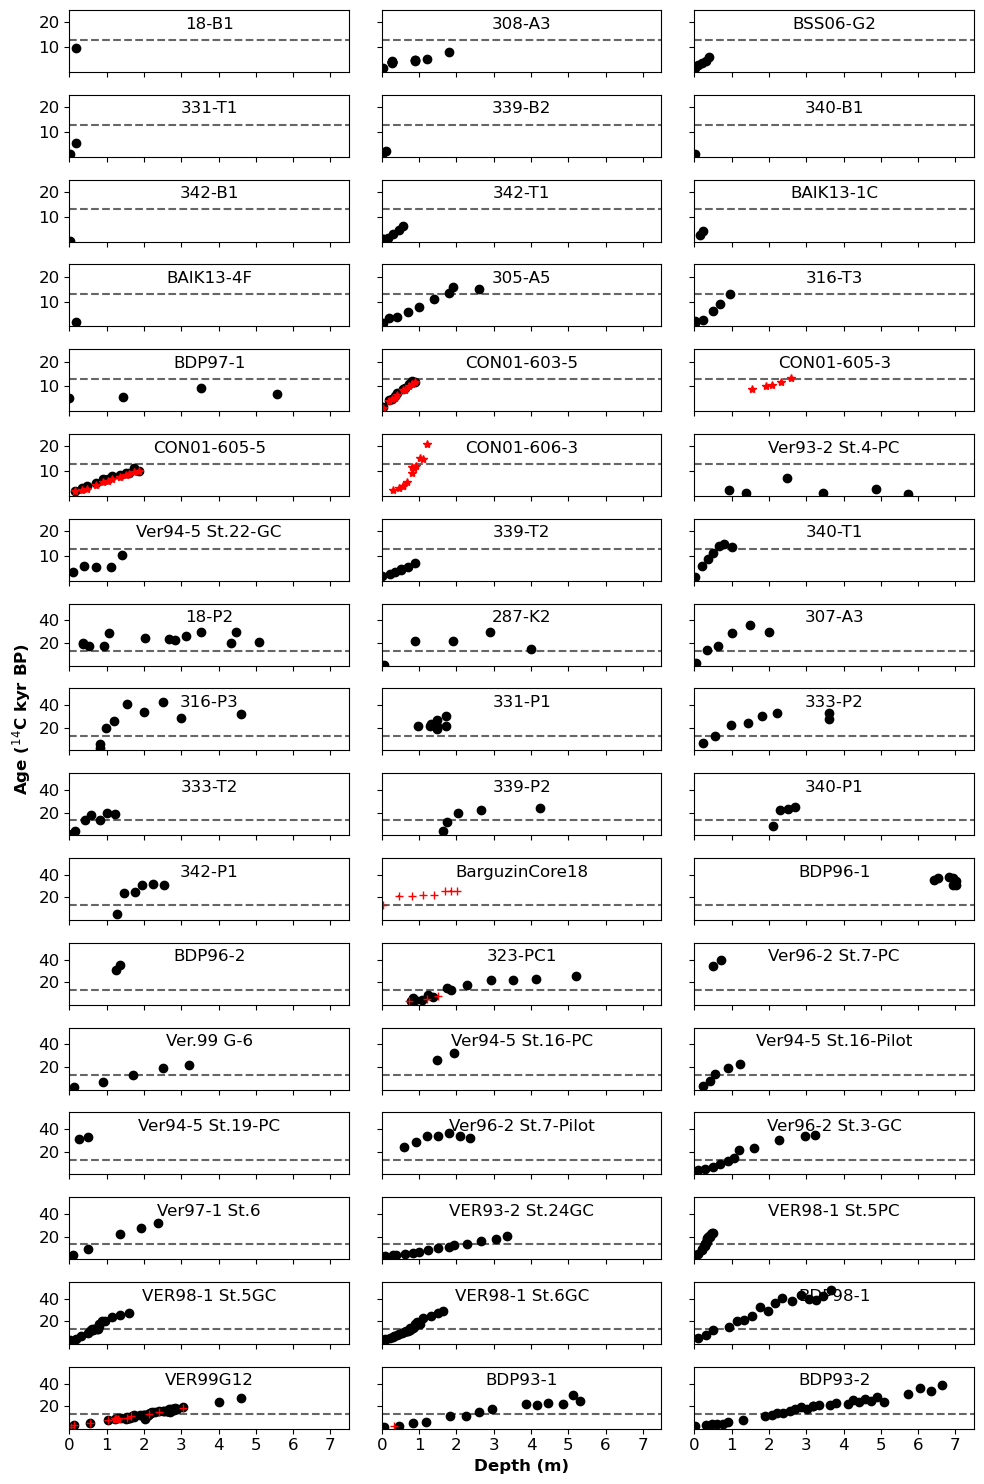

In [7]:
allcores = ['18-B1','18-P2','287-K2','305-A5','307-A3','308-A3','316-P3','316-T3','331-P1','331-T1','333-P2',\
            '333-T2','339-B2','339-P2','339-T2','340-B1','340-P1','340-T1','342-B1','342-P1','342-T1',\
            'BAIK13-1C','BAIK13-4F',\
            'BDP93-1','BDP93-2','BDP96-1','BDP96-2','BDP97-1','BDP98-1',\
            'BSS06-G2','323-PC1',\
            'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3',\
            'Ver.99 G-6','Ver93-2 St.4-PC','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver94-5 St.22-GC','Ver96-2 St.3-GC','Ver96-2 St.7-Pilot','Ver96-2 St.7-PC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','VER99G12']
 

youngcores = ['18-B1', '308-A3', 'BSS06-G2', '331-T1', '339-B2','340-B1', '342-B1',\
              '342-T1', 'BAIK13-1C', 'BAIK13-4F', '305-A5','316-T3', 'BDP97-1', \
              'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3', 'Ver93-2 St.4-PC', \
              'Ver94-5 St.22-GC',  '339-T2','340-T1' ]
    
longcores = ['18-P2','287-K2','307-A3','316-P3','331-P1','333-P2',\
            '333-T2','339-P2','340-P1','342-P1',\
            'BarguzinCore18','BDP96-1','BDP96-2','323-PC1',\
            'Ver96-2 St.7-PC','Ver.99 G-6','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver96-2 St.7-Pilot','Ver96-2 St.3-GC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','BDP98-1','VER99G12','BDP93-1','BDP93-2']
    
    
AR_ASAcores = ['Ver94-5 St.16-PC', '333-P2', '333-T2', '331-T1', '340-P1', '340-T1',\
            'Ver96-2 St.3-GC', 'VER98-1 St.6GC', 'VER98-1 St.5GC', 'Ver97-1 St.6', 'BDP98-1']  

BS_nonASAcores = ['BDP93-1', '339-P2', '316-P3']

BS_ASAcores = ['316-T3', 'BSS06-G2', '339-T2', '339-B2', 'BDP93-2', '305-A5', 'VER93-2 St.24GC', 'VER99G12']

# '.' for dot; 'o' for circle, 'v' for trinagle down, '+' for plus
plotstyles1 = ['ok', '*r', '+r', 'ok', 'ok', '+r', '+r', '+r', '+r']

def allplots(core_names, plotstyles, plotrows, plotcolumns, dfall):
    fig, axs = plt.subplots(plotrows, plotcolumns, squeeze=False)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    
    materials = [
        'TOC', 'Pollen Concentrate', 'Total Lipids', 'POM', 'FOM',
        'Wood', 'Lipid fraction', 'Bulk Silty Clay'
    ]
    
    for j, core in enumerate(core_names):
        fig_a, fig_b = divmod(j, plotcolumns)
        ax = axs[fig_a, fig_b]
        
        # subset to this core once
        rdata_core = dfall[dfall['Core Name'] == core].copy()
        if rdata_core.empty:
            ax.set_title(core + " (no data)")
            continue
        
        for i, mat in enumerate(materials):
            rd_toc = rdata_core[rdata_core['Material'] == mat].copy()
            if rd_toc.empty:
                continue
            
            # keep only rows with numeric Value and Error
            rd_toc = rd_toc[rd_toc['Value'].notna() & rd_toc['Error'].notna()]
            if rd_toc.empty:
                continue
            
            # choose depth column: prefer Corrected Depth if any numeric values exist
            use_corrected = rd_toc['Corrected Depth'].notna().any()
            if use_corrected:
                x = rd_toc['Corrected Depth']
            else:
                x = rd_toc['Middle Depth']
            
            y = rd_toc['Value']   # already in 14C kyr BP
            yerror = rd_toc['Error']  # kyr
            
            if x.empty or y.empty:
                continue
            
            fmt = plotstyles[i] if i < len(plotstyles) else '.'
            ax.errorbar(x, y, yerr=yerror, fmt=fmt)
        
        # young vs long cores
        youngAxes = fig_a in [0, 1, 2, 3, 4, 5, 6]
        if youngAxes:
            ylims = [0, 25]   # 0–25 kyr
            ax.set_ylim(ylims)
            ax.text(3.75, ylims[1]*0.7, core, horizontalalignment="center")
        else:
            ylims = [0, 55]   # 0–55 kyr
            ax.set_ylim(ylims)
            ax.text(3.75, ylims[1]*0.7, core, horizontalalignment="center")
        
        # y-ticks now in kyr
        if fig_b == 0 and youngAxes:
            ax.set_yticks([10, 20], ["10", "20"])
        elif fig_b != 0 and youngAxes:
            ax.set_yticks([10, 20], [" ", " "])
        elif fig_b == 0 and not youngAxes:
            ax.set_yticks([20, 40], ["20", "40"])
        elif fig_b != 0 and not youngAxes:
            ax.set_yticks([20, 40], [" ", " "])
        
        # x-ticks and x-label
        if fig_a == 16:
            ax.set_xticks(
                [0, 1, 2, 3, 4, 5, 6, 7],
                ["0", "1", "2", "3", "4", "5", "6", "7"]
            )
        else:
            ax.set_xticks(
                [0, 1, 2, 3, 4, 5, 6, 7],
                ["", "", "", "", "", "", "", ""]
            )
        
        if fig_b == 0 and fig_a == 8:
            ax.set_ylabel('Age ($^{14}$C kyr BP)', fontweight='bold')
        
        if fig_b == 1 and fig_a == 16:
            ax.set_xlabel('Depth (m)', fontweight='bold')
        
        ax.set_xlim([0, 7.5])
        ax.axhline(13, color='0.4', linestyle='--')
        #ax.set_title(core_names[j])
    
    plt.tight_layout()

allplots(youngcores+longcores, plotstyles1, 17, 3, dfall)
plt.savefig('../figures/allCores.png', bbox_inches = 'tight', dpi = 300)


## Compute ASA for each core

In this section, we first define the relevant functions for computing the ASA for each core.

Then, we go through each core and plot the data, choose if any dates need to be removed before analysis, then perform the computation.

As a reminder, whilst we have 51 cores in the dataset, there will be less than 51 analyses of ASA. This is because:  Some of the cores will be evaluated together (as composite cores) because they are all from the same site; Cores that do not show a clear linear pattern will not be analysed; Cores for which there are less than 2 TOC ages younger than 13 14C kyr BP cannot proide ASAs. So, there will not be 51 analyses of ASA.

Here is a list of the sites we will perform ASA at, highlighting where cores will be combined or not.

__Buguldeika Saddle__
- 305-A5
- BSS06-G2
- Site316 (316-P3, 316-T3)
- Site339 (339-P2, 339-T2, 339-B2)
- VER93-2 St.24GC
- VER99G12
- BDP93 (BDP93-1, BDP93-2)

__Academician Ridge__
- BDP98-1
- Site18 (18-P2, 18-B1)
- Site331 (331-P1, 331-T1)
- Site333 (333-T2, 333-P2)
- Site340 (340-B1, 340-T1, 340-P1)
- 307-A3
- VER98St5 (VER98-1 St.5GC, VER98-1 St.5PC)
- VER98-1 St.6GC
- Ver97-1 St.6
- VER96-2 St.3-GC
- VER96St7 (Ver96-2 St.7-Pilot, Ver96-2 St.7-PC)
- VER94St16 (Ver94-5 St.16-Pilot, Ver94-5 St.16-PC)
- VER94-5 st.19-PC
- VER93-2 st.4-PC

__Maloe More__
- Site342 (342-B1, 342-T1, 342-P1)

__Continent Ridge__
- CON01-603-5

__Posolskoe Bank__
- Ver.99 G-6
- (CON01-606-3 not considered - Pollen Ages only)

__Vydrino Shoulder__
- CON01-605-5
- (CON01-605-3 not considered - Pollen Ages only)

__North Basin__
- 323-PC1
- Ver94-5 St.22-GC

__Central Basin__
- 308-A3

__Southern Basin__
- BAIK13-1C
- BAIK13-4F (Only 1 Age)
- BDP97-1


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

#Suppress warning about legend entries starting with underscore not being shown, 
#as this is used intentionally in the plotting code to avoid duplicate legend entries
warnings.filterwarnings(
    "ignore",
    message="The label '_nolegend_'",
    category=UserWarning
)

#Define a function for OLS linear regression function from the web...
def linear_regression(x, y):     
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    
    B1_num = ((x - x_mean) * (y - y_mean)).sum()
    B1_den = ((x - x_mean)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean - (B1*x_mean)
    
    reg_line = 'y = {} + {}x'.format(round(B0, 3), round(B1, 3))
    
    return (round(B0,3), round(B1,3), reg_line)

def compiplot(core_names, xlabcodes, dfall):
    """
    Plot compiled radiocarbon ages for a set of cores using a single
    dataframe `dfall` that contains all Baikal 14C data.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    xlabcodes : list of str
        Lab codes to exclude from plotting.
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.
    """
    legendl = []
    xc = pd.Series([], dtype='float64')
    yc = pd.Series([], dtype='float64')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()

        # keep only TOC/FOM/POM
        rdata = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ]

        # keep only rows with numeric error (NaN = drop)
        rdata = rdata[rdata['Error'].notna()]

        # remove specific lab codes
        if len(xlabcodes) > 0:
            rdata = rdata[~rdata['Lab Code'].isin(xlabcodes)]

        # decide which depth column to use: corrected depth if any numeric values exist
        if rdata['Corrected Depth'].notna().any():
            x = rdata['Corrected Depth']
        else:
            x = rdata['Middle Depth']

        # y = age value and yerror = error
        y = rdata['Value']
        yerror = rdata['Error']

        # update axis limits bookkeeping
        xc = pd.concat([xc, x])
        yc = pd.concat([yc, y])

        # plot this core
        plt.errorbar(x, y, yerr=yerror, fmt='.')
        legendl.append(core)

    # axis labels and limits
    if len(xc) > 0 and len(yc) > 0:
        plt.xlabel('Depth (m)')
        plt.ylabel('Age (14C kyr BP)')
        plt.xlim(0, 1.1 * xc.max())
        plt.ylim(0, 1.1 * yc.max())
        plt.legend(legendl, loc=0)
        
        
def compiplot_grey(core_names, xlabcodes, dfall):
    """
    Plot compiled radiocarbon ages (with grey >13k and marked rejections)
    for a set of cores using a single dataframe `dfall`.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    xlabcodes : list of str
        Lab codes to exclude (plotted separately as 'Rejected').
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.
    """
    legendl = []
    xc_all = pd.Series([], dtype='float64')
    xc      = pd.Series([], dtype='float64')
    xcGrey  = pd.Series([], dtype='float64')
    xcXcode = pd.Series([], dtype='float64')
    yc      = pd.Series([], dtype='float64')
    yc_all  = pd.Series([], dtype='float64')
    ycerror = pd.Series([], dtype='float64')
    ycGrey  = pd.Series([], dtype='float64')
    ycerrorGrey  = pd.Series([], dtype='float64')
    ycXcode      = pd.Series([], dtype='float64')
    ycerrorXcode = pd.Series([], dtype='float64')
    

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue  # nothing to plot for this core

        # TOC/FOM/POM only
        rd_tocall = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ].copy()
        if rd_tocall.empty:
            continue

        # keep only rows with numeric error
        rd_tocerror = rd_tocall[rd_tocall['Error'].notna()].copy()
        if rd_tocerror.empty:
            continue

        # split into kept vs excluded (xlabcodes)
        rd_toc      = rd_tocerror[~rd_tocerror['Lab Code'].isin(xlabcodes)].copy()
        rd_tocXcode = rd_tocerror[ rd_tocerror['Lab Code'].isin(xlabcodes)].copy()

        if rd_toc.empty and rd_tocXcode.empty:
            continue

        # younger vs older than 13,000 14C yr BP
        rd_toc13  = rd_toc[rd_toc['Value'] < 13].copy()
        rd_tocg13 = rd_toc[rd_toc['Value'] >= 13].copy()

        # decide which depth column to use (prefer corrected if any numeric)
        use_corrected = rd_tocall['Corrected Depth'].notna().any()

        if use_corrected:
            x_all  = rd_tocall['Corrected Depth']
            x      = rd_toc13['Corrected Depth']
            xGrey  = rd_tocg13['Corrected Depth']
            xXcode = rd_tocXcode['Corrected Depth']
        else:
            x_all  = rd_tocall['Middle Depth']
            x      = rd_toc13['Middle Depth']
            xGrey  = rd_tocg13['Middle Depth']
            xXcode = rd_tocXcode['Middle Depth']
        

        # y values in 14C kyr BP
        y_all  = rd_tocall['Value']
        y      = rd_toc13['Value']
        yGrey  = rd_tocg13['Value'] 
        yXcode = rd_tocXcode['Value']

        # errors in kyr
        yerror      = rd_toc13['Error']  
        yerrorGrey  = rd_tocg13['Error']   
        yerrorXcode = rd_tocXcode['Error'] 

        # accumulate for global limits
        xc_all = pd.concat([xc_all, x_all])
        yc_all = pd.concat([yc_all, y_all])
        xc     = pd.concat([xc, x])
        yc     = pd.concat([yc, y])
        xcGrey = pd.concat([xcGrey, xGrey])
        ycGrey = pd.concat([ycGrey, yGrey])
        xcXcode = pd.concat([xcXcode, xXcode])
        ycXcode = pd.concat([ycXcode, yXcode])
        ycerror      = pd.concat([ycerror, yerror])
        ycerrorGrey  = pd.concat([ycerrorGrey, yerrorGrey])
        ycerrorXcode = pd.concat([ycerrorXcode, yerrorXcode])

        # legend entries
        legendl.append(core)

        # main errorbar: all points
        plt.errorbar(
            pd.concat([x, xGrey, xXcode]),
            pd.concat([y, yGrey, yXcode]),
            yerr=pd.concat([yerror, yerrorGrey, yerrorXcode]),
            fmt='.', ms=8
        )
        
    # grey points (older than 13k)
    if not xcGrey.empty:
        plt.errorbar(xcGrey,  ycGrey,  yerr=0, fmt='x', color='0.6')
        legendl.append('> 13 14C kyr BP')
    # rejected points (xlabcodes)
    if not xcXcode.empty:
        plt.errorbar(xcXcode, ycXcode, yerr=0, fmt='x', color='0')
        legendl.append('Rejected')

    plt.xlabel('Depth (m)')
    plt.ylabel('Age ($^{14}$C kyr BP)')

    if not xc_all.empty and not yc_all.empty:
        plt.xlim(0, 1.1 * xc_all.max())
        plt.ylim(0, 1.1 * yc_all.max())
    plt.legend(legendl, loc=0)

def ASA13_grey(core_names, xlabcodes, dfall):
    """
    Compute ASA using only data in dfall, and plot using compiplot_grey.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    xlabcodes : list of str
        Lab codes to exclude from the regression and mark as rejected.
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.

    Returns
    -------
    float or str
        ASA (intercept, in 14C kyr BP) if regression is possible,
        otherwise a message.
    """

    # Set up empty vectors to store combined depth/age data
    xC = pd.Series([], dtype='float64')
    yC = pd.Series([], dtype='float64')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue

        # choose only TOC/FOM/POM
        rd_toc = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ].copy()
        if rd_toc.empty:
            continue

        # keep only rows with a non-missing lab code
        rd_toc = rd_toc[rd_toc['Lab Code'].notna()].copy()
        if rd_toc.empty:
            continue

        # keep only rows with numeric error
        rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
        if rd_toc.empty:
            continue

        # remove specific data points by lab code
        if len(xlabcodes) > 0:
            rd_toc = rd_toc[~rd_toc['Lab Code'].isin(xlabcodes)].copy()
        if rd_toc.empty:
            continue

        # select only data younger than 13,000 14C yr BP
        rd_toc13 = rd_toc[rd_toc['Value'] < 13].copy()
        if rd_toc13.empty:
            continue

        # choose depth column: prefer corrected depth if any numeric values exist
        use_corrected = rd_toc13['Corrected Depth'].notna().any()
        if use_corrected:
            x = rd_toc13['Corrected Depth']
        else:
            x = rd_toc13['Middle Depth']

        # age in 14C kyr BP
        y = rd_toc13['Value']

        xC = pd.concat([xC, x])
        yC = pd.concat([yC, y])

    # Need at least 2 points for a regression
    if len(xC) > 1:
        lin = linear_regression(xC, yC)

        # make the grey plot using the dfall-based version
        figasa = compiplot_grey(core_names, xlabcodes, dfall)

        # regression line up to 13 kyr
        xlin = np.linspace(0, (13 - lin[0]) / lin[1], 10)
        ylin = lin[1] * xlin + lin[0]
        plt.plot(xlin, ylin, '--', linewidth=0.7, color='0')

        ax = plt.gca()
        plt.text(
            0.85, 0.4,
            "ASA = " + str(round(lin[0], 3)),
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes
        )

        return lin[0]
    else:
        return 'Not enough data younger than 13 14C kyr BP to perform linear regression'

def ASAall(core_names, xlabcodes, dfall):

    #Set up empty vectors to store the important info
    xC = pd.Series([], dtype='int32')
    yC = pd.Series([], dtype='int32')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue

        # choose only TOC/FOM/POM
        rd_toc = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ].copy()
        if rd_toc.empty:
            continue

        # keep only rows with a non-missing lab code
        rd_toc = rd_toc[rd_toc['Lab Code'].notna()].copy()
        if rd_toc.empty:
            continue

        # keep only rows with numeric error
        rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
        if rd_toc.empty:
            continue

        # remove specific data points by lab code
        if len(xlabcodes) > 0:
            rd_toc = rd_toc[~rd_toc['Lab Code'].isin(xlabcodes)].copy()
        if rd_toc.empty:
            continue

        # choose depth column: prefer corrected depth if any numeric values exist
        use_corrected = rd_toc['Corrected Depth'].notna().any()
        if use_corrected:
            x = rd_toc['Corrected Depth']
        else:
            x = rd_toc['Middle Depth']

        # age in 14C kyr BP
        y = rd_toc['Value']

        xC = pd.concat([xC, x])
        yC = pd.concat([yC, y])

    
    if len(xC) > 1:
        lin = linear_regression(xC, yC)
        figasa = compiplot(core_names, xlabcodes, dfall)
        plt.xlim(0,1.1*max(xC))
        plt.ylim(0,1.1*max(yC))
        xlin = np.linspace(0,1.1*max(xC), 10)
        ylin = lin[1]*xlin +lin[0]
        plt.plot(xlin,ylin,'-.r',linewidth = 0.5)
        return(lin[0])
    else:
        return('Not enough data to perform linear regression')
    
    
    
def compiplot_2ref(core_names, ref1, ref2, commonname, dfall):
    """
    Compare 14C ages from two reference sources (ref1, ref2)
    for a set of cores, using the master dataframe `dfall`.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    ref1, ref2 : str
        Reference strings to compare (e.g., 'Colman et al., 1996').
    commonname : str
        Title for the plot.
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.
    """

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue

        # TOC only
        rd_toc = rdata[rdata['Material'] == 'TOC'].copy()
        if rd_toc.empty:
            continue

        # keep only rows with numeric error
        rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
        if rd_toc.empty:
            continue

        # split by reference
        rd_tocr1 = rd_toc[rd_toc['Reference'] == ref1].copy()
        rd_tocr2 = rd_toc[rd_toc['Reference'] == ref2].copy()

        if rd_tocr1.empty and rd_tocr2.empty:
            continue

        # choose depth column: prefer corrected if any numeric values exist
        use_corrected_r1 = rd_tocr1['Corrected Depth'].notna().any()
        use_corrected_r2 = rd_tocr2['Corrected Depth'].notna().any()

        if use_corrected_r1:
            xr1 = rd_tocr1['Corrected Depth']
        else:
            xr1 = rd_tocr1['Middle Depth']

        if use_corrected_r2:
            xr2 = rd_tocr2['Corrected Depth']
        else:
            xr2 = rd_tocr2['Middle Depth']

        # ages and errors
        yr1 = rd_tocr1['Value']
        yr2 = rd_tocr2['Value']
        yerrorr1 = rd_tocr1['Error']
        yerrorr2 = rd_tocr2['Error']

        # plot for this core
        if not rd_tocr1.empty:
            plt.errorbar(xr1, yr1, yerr=yerrorr1, fmt='.', label=f"{core}: {ref1}")
        if not rd_tocr2.empty:
            plt.errorbar(xr2, yr2, yerr=yerrorr2, fmt='.', label=f"{core}: {ref2}")

        plt.xlabel('Depth (m)')
        plt.ylabel('Age (14C kyr BP)')  # change to 'kyr BP' + rescale limits if Value is now in kyr

        # These fixed limits assume Value is still in years.
        # If you've converted to kyr, change to, e.g., ylim([0, 40]) and adjust the label.
        plt.xlim([0, 13])
        plt.ylim([0, 40])

    plt.legend()
    plt.title(commonname)

## ASA estimates

Plot radiocarbon dates from each individual core or site, evaluate if any data should be removed, and calculate offset.



#### Core 305-A5

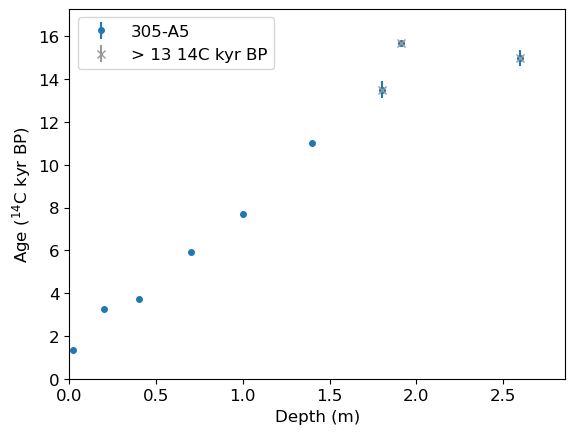

In [9]:
compiplot_grey(['305-A5'],[], dfall)

Core 305-A5 has a potential reversal near the bottom of the core but those ages are older than 13 14C kyr BP hence we need not worry about how they might affect the apparent surface age calculation we will perform.

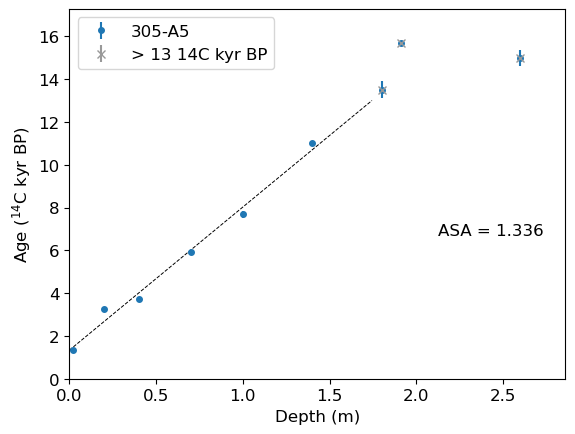

In [10]:
asa305 = ASA13_grey(['305-A5'], [], dfall)

#### Core BSS06-G2

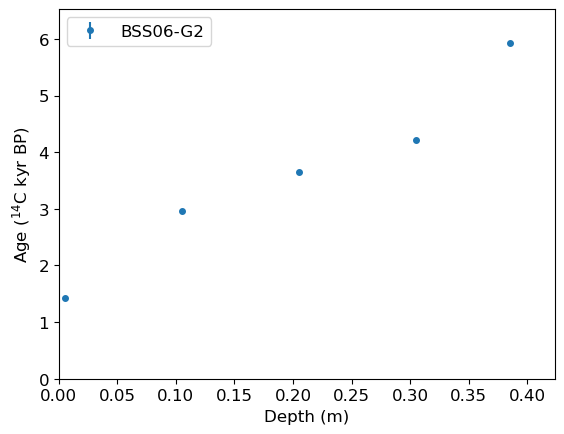

In [11]:
compiplot_grey(['BSS06-G2'], [], dfall)

The data from BSS06-G2 looks relatively linear with no reversals, so we do not remove any ages.

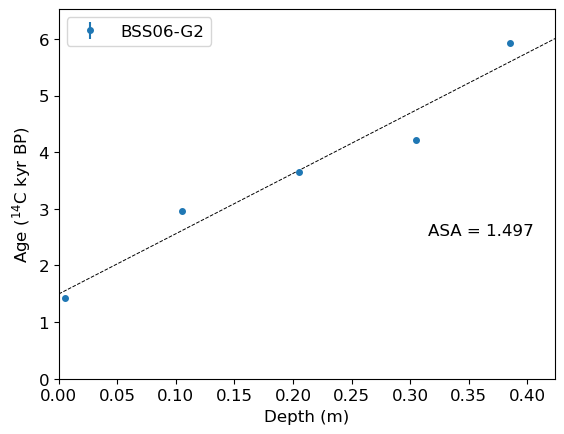

In [12]:
asaBSS06 = ASA13_grey(['BSS06-G2'],[], dfall)

#### Site 316

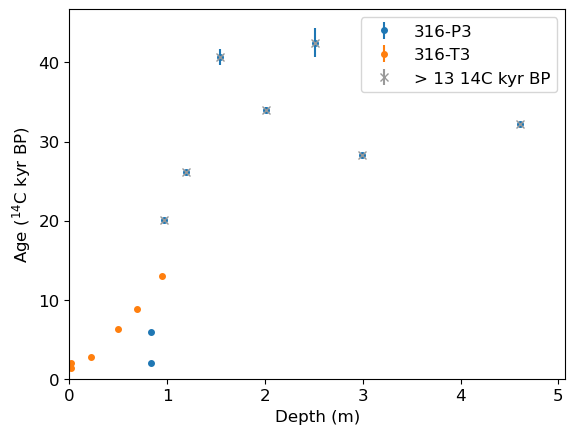

In [13]:
#Run through the '316-' cores data and plot them on a single plot
cores_316 = ['316-P3', '316-T3']
compiplot_grey(cores_316, [], dfall)

It seems there is a clear linear sedimentation pattern suggested by 316-T3 but not by 316-P3. The youngest two ages in 316-P3 violate the law of superposition (when considered with 316-T3), hence we will reject them. The rest of the ages in 316-P3 are older than 13 14C kry BP, so they will not affect the analysis at all.

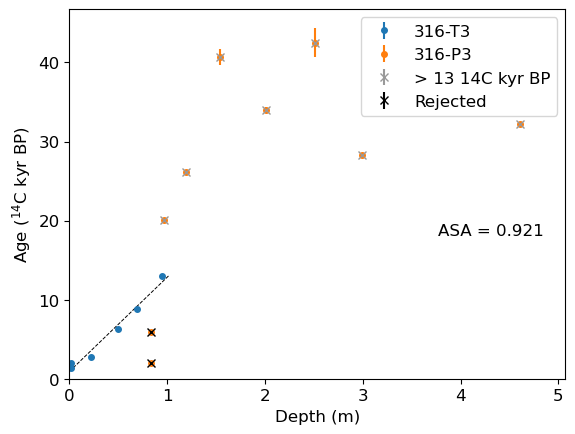

In [14]:
cores_316 = ['316-T3', '316-P3']

asa316 = ASA13_grey(cores_316, ['OS-00462','OS-00821'], dfall)

#### Site 339

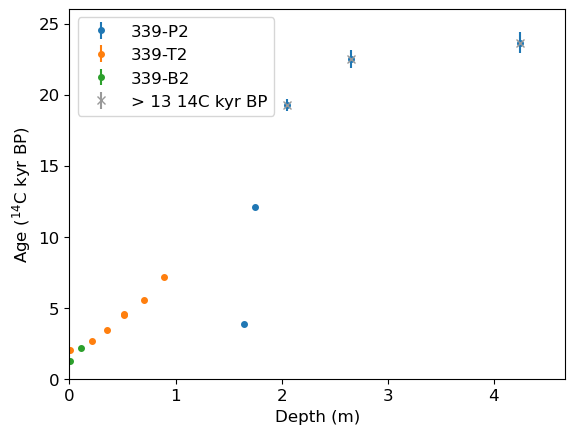

In [15]:
cores_339 = ['339-P2', '339-T2', '339-B2']

compiplot_grey(cores_339, [], dfall)

The shallowest age in 339-P2 violates the rule of superposition so we reject it. It could be argued that all of the data from core 339-P2 should be removed, because it does not follow a linear pattern. However, after removing the shallowest age from 339-P2, the ages comply with the rule of superposition.

There are two options:
- Option 1 - Only reject shallowest age from 339-P2
- Option 2 - Reject all ages from 339-P2

Colman et al. (1996) performed their linear regression on this site following Option 1. They returned an intercept of 1.48 14C ky. Let us first follow Option 1.

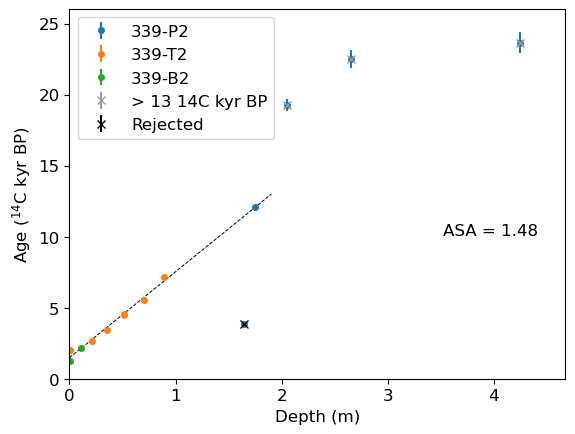

In [16]:
asa339_opt1 = ASA13_grey(cores_339,['CAMS-7572'], dfall)
plt.savefig("../figures/ASAexample.png", dpi=300, bbox_inches="tight")

Our analysis confirms the reproducibility of the Colman et al. (1996) intercept value for this site.

Let us also try Option 2.

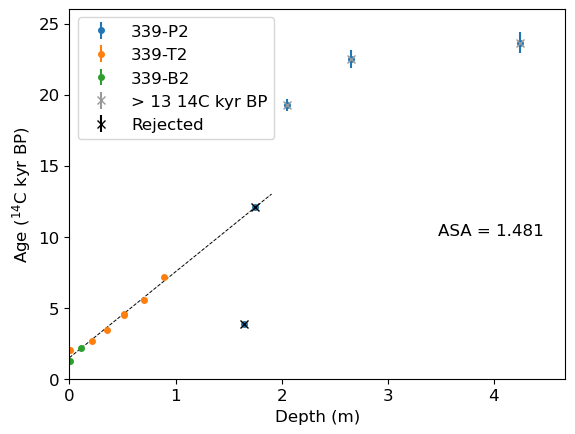

In [17]:
#Reject all dates from 339-P2

asa339_opt2 = ASA13_grey(cores_339,['CAMS-7572', 'CAMS-8897'],dfall)

We find the intercept is still 1.48 14C kyr BP, so we consider the two options equivalent. We will use the result produced by Option 2 going forward.

#### Core VER93-2 St.24GC

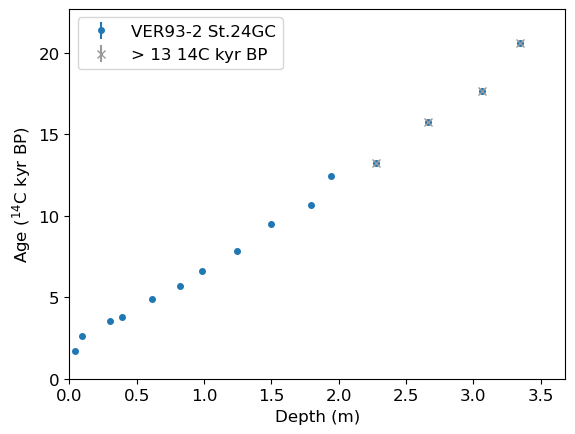

In [18]:
compiplot_grey(['VER93-2 St.24GC'], [],dfall)

There are no ages that violate the law of superposition, so we will not exclude any ages.

For context, Karabanov et al. (2004) applied a linear regression to this core finding an intercept of 1588 14C yr BP, however they include all ages, whereas the method we use here - based on the method of Colman et al. (1996) - uses only ages younger than 13 14C kyr BP.

First, however, let us attempt to reproduce the value of Karabanov et al. (2004) by applying an intercept method using all ages.

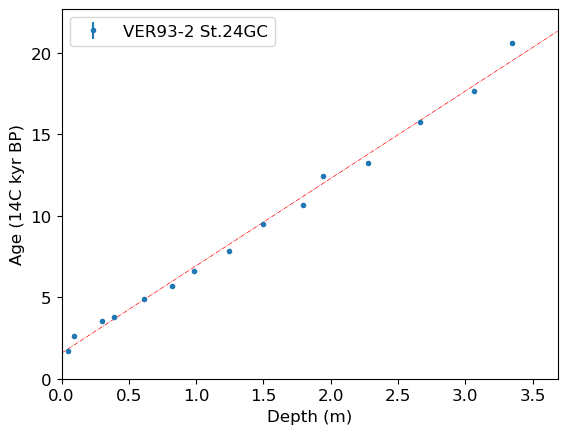

In [19]:
asaVER93 = ASAall(['VER93-2 St.24GC'], [],dfall)

The intercept we return, 1569, is very similar to but not the exact same as the intercept of 1588 reported by Karabanov et al. (2004).

Next, we calculate the ASA using our intercept method.

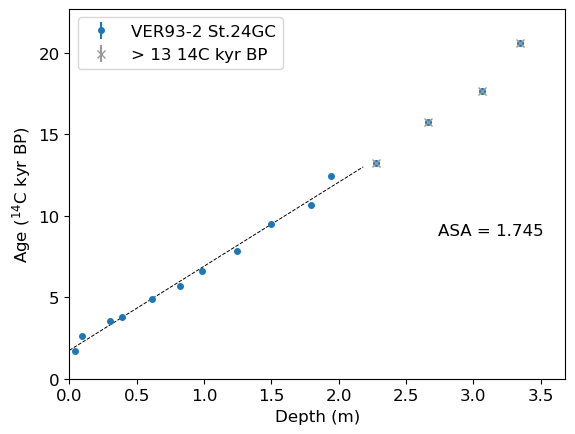

In [20]:
asaVER93 = ASA13_grey(['VER93-2 St.24GC'], [],dfall)

#### Core VER99G12

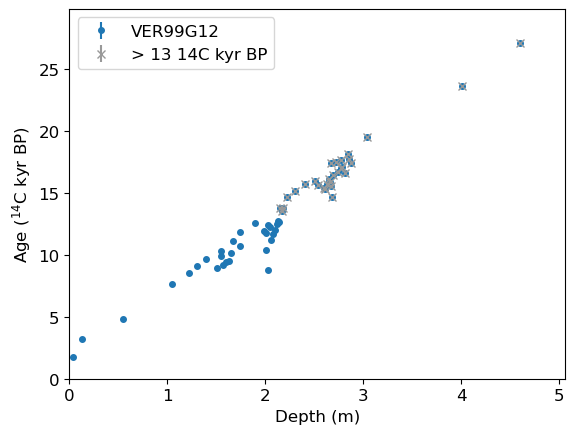

In [21]:
compiplot_grey(['VER99G12'], [],dfall)

There is a clear linear pattern suggested by the dates but there are many dates that do not comply with the law of superposition. Below (at greater depth than) the date at 189.5cm (with an age of 12571 14C yr BP) there are a number of dates that look anomalously young. There are also a number of ages in the depth interval of 150-165cm that do not comply with the law of superposition. 

We condsider 3 options here:
- Option 1 - Remove no dates
- Option 2 - Remove dates below the depth of 190cm
- Option 3 - Remove dates below the depth of 190cm AND remove the dates in the 150-165 cm range

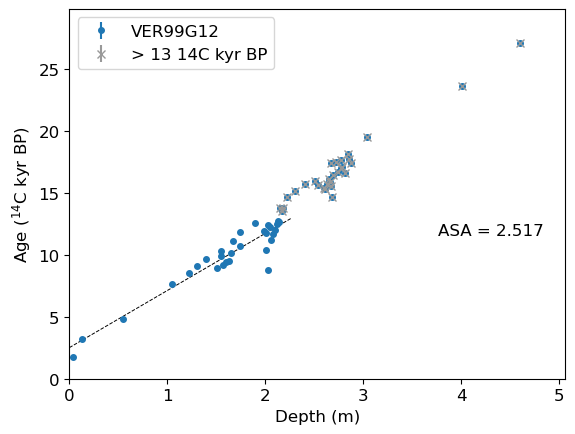

In [22]:
VER99_xcodes_opt1 = []
asaVER99_opt1 = ASA13_grey(['VER99G12'],VER99_xcodes_opt1,dfall)

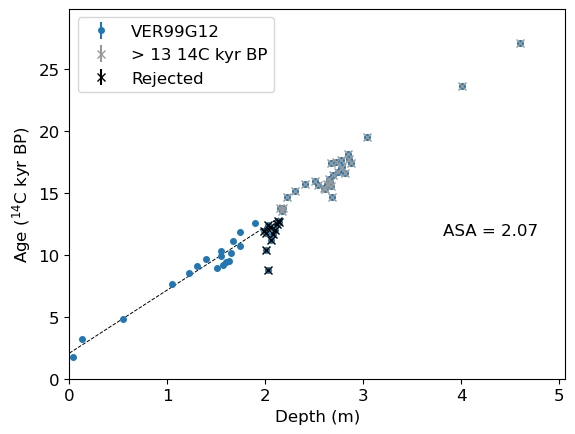

In [23]:
VER99_xcodes_opt2 = ['NUTA2-13986', 'NUTA2-13255','NUTA2-9603','NUTA-10717','NUTA2-13257','NUTA2-13989','NUTA2-9602', 'JAT-12144', 'JAT-12145', 'JAT-12146', 'JAT-12147', 'JAT-12148']
asaVER99_opt2 = ASA13_grey(['VER99G12'],VER99_xcodes_opt2,dfall)

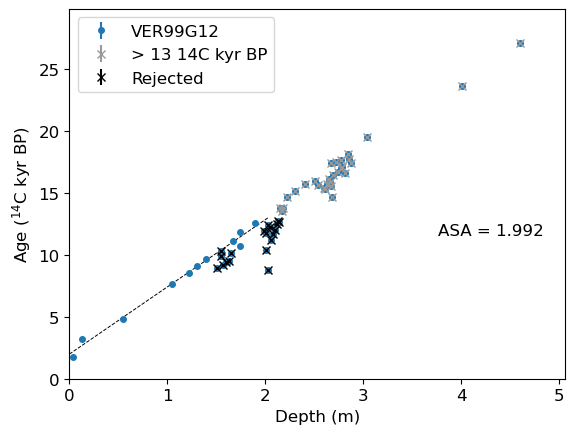

In [24]:
VER99_xcodes_opt3 = ['NUTA2-13986', 'NUTA2-13255','NUTA2-9603','NUTA-10717','NUTA2-13257','NUTA2-13989','NUTA2-9602', 'JAT-12144', 'JAT-12145', 'JAT-12146', 'JAT-12147', 'JAT-12148', 'NUTA2-13254', 'NUTA2-13991','NUTA2-8902', 'NUTA2-13992', 'NUTA2-10711', 'NUTA2-13993', 'NUTA2-9597']
asaVER99_opt3 = ASA13_grey(['VER99G12'],VER99_xcodes_opt3,dfall)

We choose option 3 to move forward with.

#### BDP93



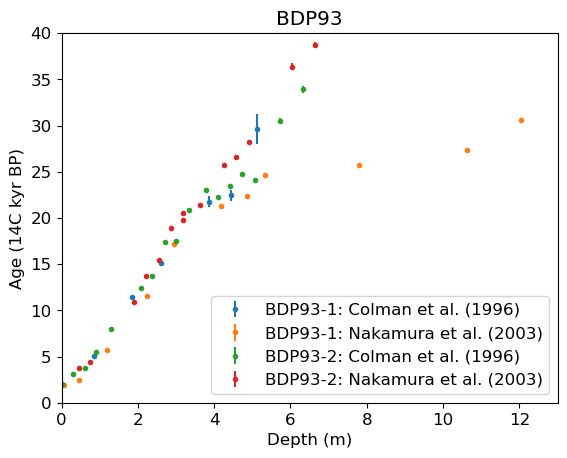

In [25]:
#Plot all BDP93 cores, distinguishing between the two cores and the two studies that reported ages
BDP93_cores = ['BDP93-1', 'BDP93-2']
compiplot_2ref(BDP93_cores,'Colman et al. (1996)','Nakamura et al. (2003)','BDP93',dfall)


Here we observe something that was noted by Colman et al. 1996. The BDP93-1 has some very deep sections that were analysed for radiocarbon, and we see that they suggest a much higher sedimentation rate than the deep analyses in BDP93-2. (Note, the data that Colman used to observe this are not actually in the figure above because they do not have associated age uncertainties and hence are discarded, however somewhat similar results are observed from the Nakamura et al. 2003 data.).

Colman et al. 1996 reported that this was due to the poor storage conditions of the BDP93-1 core, which was seen to have visible organic growth on the outside of the sample. It is possible therefore that the samples was contaminated by a small amount of modern carbon, which would have disproportionately affected the older samples. Colman et al. 1996 did not, however, reject all BDP93-1 radiocarbon analyses, only the older, visibly younger samples.

Deciding to reject some deeper samples from BDP93-1, but not the entire core, raises the question of what cutoff point should be used. It suggests some greater uncertainty be assigned to the young BDP93-1 core dates.

Regardless, let us assess Colman et al. 1996's evaluation of the apparent surface age of the BDP93 core. Assuming we needn't discard all data from BDP93-1, and also that the cutoff point for which deeper samples to remove is significantly deep that it does not remove any data with ages younger than 13k, we can follow Colman's methodology below. First, we perform the linear regression on the Colman et al. 1996 data from both cores (test repeatability of Colman's results).

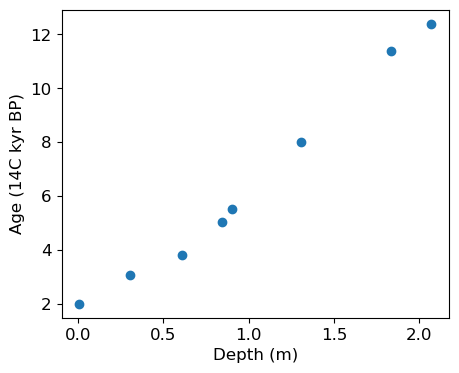

(1.16, 5.32, 'y = 1.16 + 5.32x')

In [26]:
#We do not use the ASA13 function here, because it doesn't have the functionality to select only the Nakamura data.

#Set up empty vectors to store the important info
xBDP93C = pd.Series([], dtype='int32')
yBDP93C = pd.Series([], dtype='int32')

BDP93_cores = ['BDP93-1', 'BDP93-2']
core_names = BDP93_cores
ref1 = 'Colman et al. (1996)'
for core in core_names:
    # subset to this core
    rdata = dfall[dfall['Core Name'] == core].copy()
    if rdata.empty:
        continue

    # TOC only
    rd_toc = rdata[rdata['Material'] == 'TOC'].copy()
    if rd_toc.empty:
        continue

    # keep only rows with numeric error
    rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
    if rd_toc.empty:
        continue

    # split by reference
    rd_tocr1 = rd_toc[rd_toc['Reference'] == ref1].copy()

        
    rd_tocr113 = rd_tocr1[rd_tocr1['Value'] < 13]

    # choose depth column: prefer corrected if any numeric values exist
    use_corrected_r1 = rd_tocr113['Corrected Depth'].notna().any()
    if use_corrected_r1:
        xr1 = rd_tocr113['Corrected Depth']
    else:
        xr1 = rd_tocr113['Middle Depth']

    # ages and errors
    yr1 = rd_tocr113['Value']
    yerrorr1 = rd_tocr113['Error']
    
    xBDP93C = pd.concat([xBDP93C, xr1])
    yBDP93C = pd.concat([yBDP93C, yr1])
    
plt.figure(figsize=(5,4))
plt.scatter(xBDP93C, yBDP93C)
plt.xlabel("Depth (m)")
plt.ylabel("Age (14C kyr BP)")
plt.show()
    
linear_regression(xBDP93C, yBDP93C)

We do indeed find Colman's value of 1.16 14C kyr repeatable, with his data.

What about with only the Nakamura et al. 2003 data?

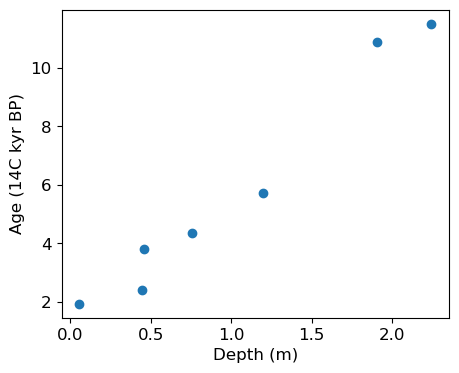

(1.056, 4.713, 'y = 1.056 + 4.713x')

In [27]:
#We do not use the ASA13 function here, because it doesn't have the functionality to select only the Nakamura data.

#Set up empty vectors to store the important info
xBDP93C = pd.Series([], dtype='int32')
yBDP93C = pd.Series([], dtype='int32')

BDP93_cores = ['BDP93-1', 'BDP93-2']
core_names = BDP93_cores
ref2 = 'Nakamura et al. (2003)'
for core in core_names:
    # subset to this core
    rdata = dfall[dfall['Core Name'] == core].copy()
    if rdata.empty:
        continue

    # TOC only
    rd_toc = rdata[rdata['Material'] == 'TOC'].copy()
    if rd_toc.empty:
        continue

    # keep only rows with numeric error
    rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
    if rd_toc.empty:
        continue

    # split by reference, choosing the Nakamura ages
    rd_tocr1 = rd_toc[rd_toc['Reference'] == ref2].copy()

        
    rd_tocr113 = rd_tocr1[rd_tocr1['Value'] < 13]

    # choose depth column: prefer corrected if any numeric values exist
    use_corrected_r1 = rd_tocr113['Corrected Depth'].notna().any()
    if use_corrected_r1:
        xr1 = rd_tocr113['Corrected Depth']
    else:
        xr1 = rd_tocr113['Middle Depth']

    # ages and errors
    yr1 = rd_tocr113['Value']
    yerrorr1 = rd_tocr113['Error']
    
    xBDP93C = pd.concat([xBDP93C, xr1])
    yBDP93C = pd.concat([yBDP93C, yr1])
    
plt.figure(figsize=(5,4))
plt.scatter(xBDP93C, yBDP93C)
plt.xlabel("Depth (m)")
plt.ylabel("Age (14C kyr BP)")
plt.show()
    
linear_regression(xBDP93C, yBDP93C)

The intercept when only using data from Nakamura et al. (2003) is 1056 14C yr BP, so is approximately 100 14C yr less than when using data from Colman et al. (1996).

Let us look at the intercept using data from both cores and both references.

1.151

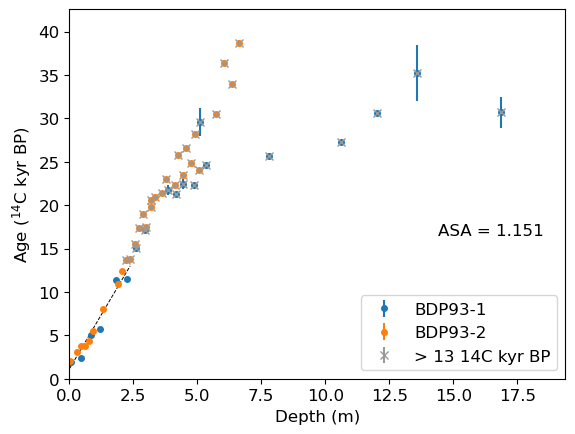

In [28]:
ASA13_grey(BDP93_cores,[],dfall)

We find the result, 1.15 14C kyr BP, is quite simlar to the Colman et al. (1996) result.

Knowing about the contamination seen in BDP93-1 (Colman et al. 1996), we are interested to see if there is any significant difference between the apparent surface age of BDP93-1 and BDP93-2. Below we estimate the ASA of BDP93-1 and BDP93-2 separately, each time using data from both Colman et al. (1996) and Nakamura et al. (2003).

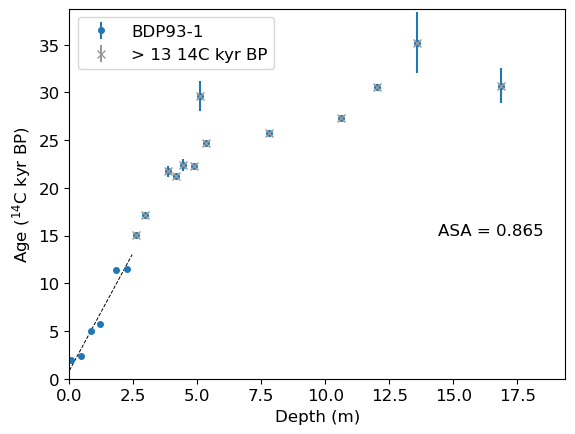

In [29]:
#Using only BDP93-1, from both sources
asaBDP931 = ASA13_grey(['BDP93-1'],[], dfall)


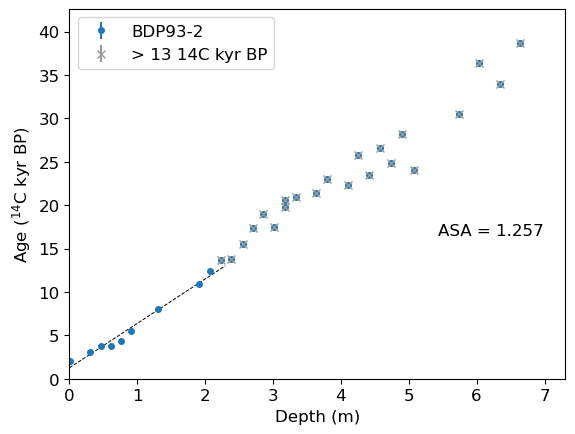

In [30]:
#Using only BDP93-2, from both sources
asaBDP932 = ASA13_grey(['BDP93-2'],[], dfall)

In [31]:
print('The apparent surface age for core BDP93-1 is ' + str(asaBDP931) + ' 14C kyr BP')
print('The apparent surface age for core BDP93-2 is ' + str(asaBDP932) + ' 14C kyr BP')

The apparent surface age for core BDP93-1 is 0.865 14C kyr BP
The apparent surface age for core BDP93-2 is 1.257 14C kyr BP


The difference in apparent surface age is approximately 400 14C yr. Based on the knowledge of the contamination of BDP93-1, we believe a better approximation of the apparent surface age for this core would be 1.26 14C kyr BP, not the 1.16 suggested by Colman et al. 1996.

#### Buguldeika Saddle Results

In the whole of the Buguldeika Saddle, there are 7 ASA estimates.

In [32]:
BS_asas = [asa305, asa316, asa339_opt2, asaBDP932, asaVER99_opt3, asaVER93, asaBSS06]
nBS_asas = np.asarray(BS_asas, dtype=float)
mBS = sum(BS_asas)/len(BS_asas)
rBS = max(BS_asas)-min(BS_asas)
varBS = sum((BS_asas - mBS) ** 2) / len(BS_asas)
stdBS = math.sqrt(varBS)

print([BS_asas])
print('The min and max apparent surface ages of the cores at Buguldeika Saddle are '+ str(round(min(BS_asas), 3))+' and '+ str(round(max(BS_asas),3))+' 14C kyr BP respectively')

print('The ASAs at Buguldeika Saddle have a mean and standard deviation of '+ str(round(mBS,3))+' ± ' + str(round(stdBS,3)) +  ' 14C kyr BP, as calculated from ' + str(len(BS_asas))+ ' cores.')


[[1.336, 0.921, 1.481, 1.257, 1.992, 1.745, 1.497]]
The min and max apparent surface ages of the cores at Buguldeika Saddle are 0.921 and 1.992 14C kyr BP respectively
The ASAs at Buguldeika Saddle have a mean and standard deviation of 1.461 ± 0.319 14C kyr BP, as calculated from 7 cores.


If we look only at the cluster of cores that are very close to each other in the North Buguldeika Saddle, there are just 4 ASA estimates.

In [33]:
BScluster_asas = (asaVER99_opt3, asaVER93, asaBDP932, asa339_opt2)
BScluster_asamean = sum(BScluster_asas)/len(BScluster_asas)
BScluster_range = max(BScluster_asas) - min(BScluster_asas)
BScluster_variance = sum((BScluster_asas - BScluster_asamean) ** 2) / len(BScluster_asas)
BScluster_std = math.sqrt(BScluster_variance)
BScluster_uncertainty = BScluster_range/2

print('The age offset at North Buguldeika Saddle is estimated to be ' + str(round(BScluster_asamean,3)) + ' ± ' + str(round(BScluster_std,3)) + ' 14C kyr BP')

The age offset at North Buguldeika Saddle is estimated to be 1.619 ± 0.276 14C kyr BP


### Academician Ridge

#### Site 18

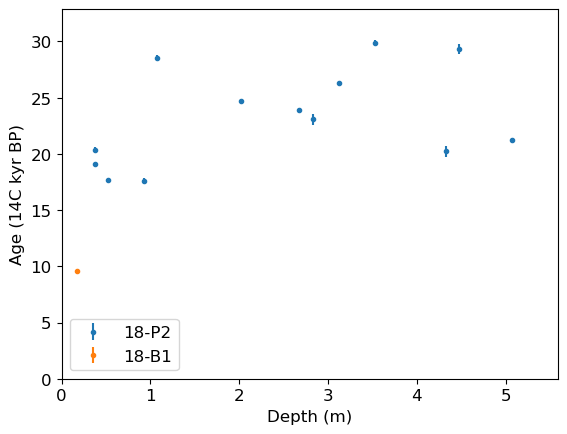

In [34]:
#Run through the '18-' cores data and plot them on a single plot
cores_18 = ['18-P2', '18-B1']
compiplot(cores_18, [],dfall)

The plot of site 18 tells us we cannot expect any linear pattern to be revealed from this data. There is only 1 age younger than 13 14C kyr BP, so we do not calculate any ASA here.

#### Site 333

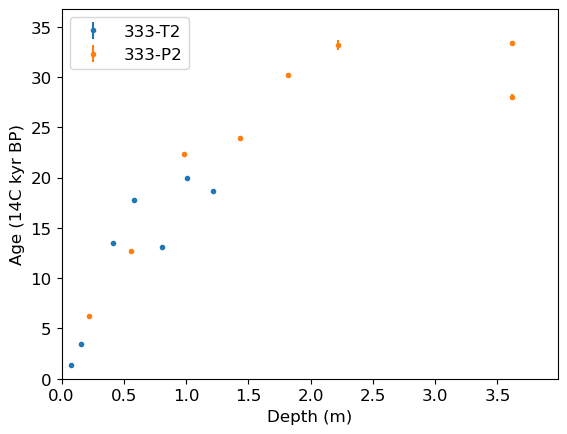

In [35]:
#Run through the '333-' cores data and plot them on a single plot
cores_333 = ['333-T2', '333-P2']
compiplot(cores_333, [],dfall)

There are a number of difficult ages here, between the depths of around 50 to 150cm, however these ages are all older than 13 14C kyr BP, so we can simply perform the ASA analysis.

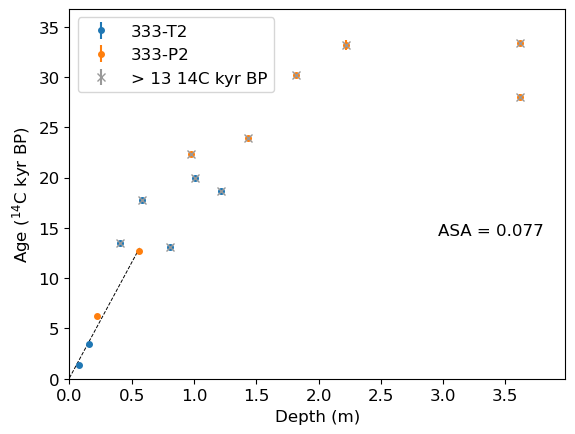

In [36]:
asa333 = ASA13_grey(cores_333, [],dfall)

#### Site 340

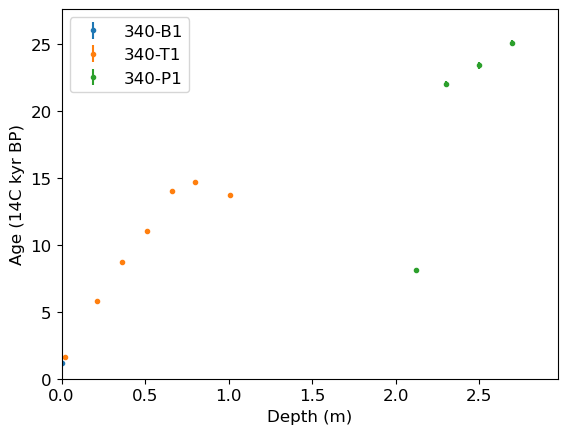

In [37]:
#Run through the '340-' cores data and plot them on a single plot
cores_340 = ['340-B1', '340-T1', '340-P1']

compiplot(cores_340, [],dfall)

There is a clear reversal at the deep end of 340-T1, but this is older than 13 14C kyr BP so we need not address it. There is a problematic age seen in 340-P1, which we remove.

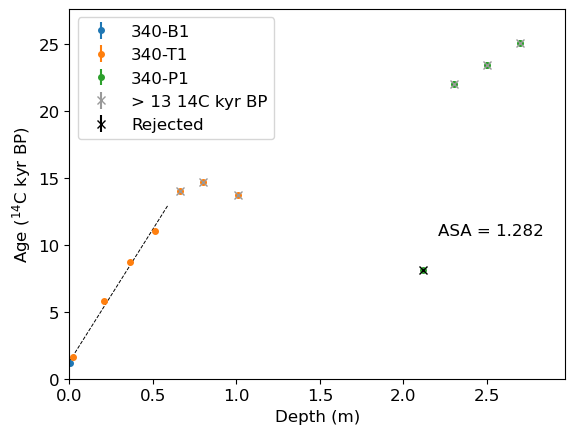

In [38]:
#Note the lab codes of data to remove
xlabcodes_340 = ['CAMS-8891']

asa340 = ASA13_grey(cores_340, xlabcodes_340,dfall)

#### Site 307

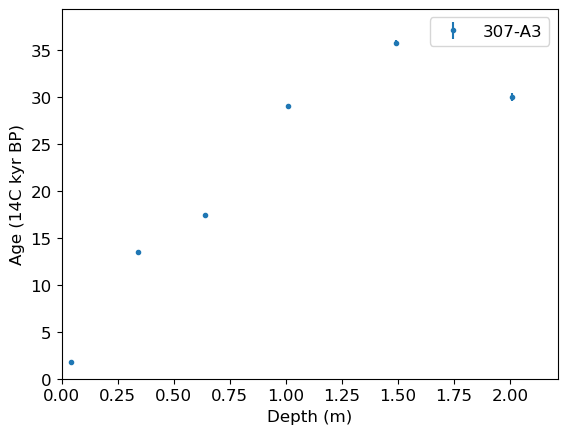

In [39]:
compiplot(['307-A3'], [],dfall)

There is not enough data younger than 13 14C kyr BP to perform our linear regression analysis here.

#### Site 331

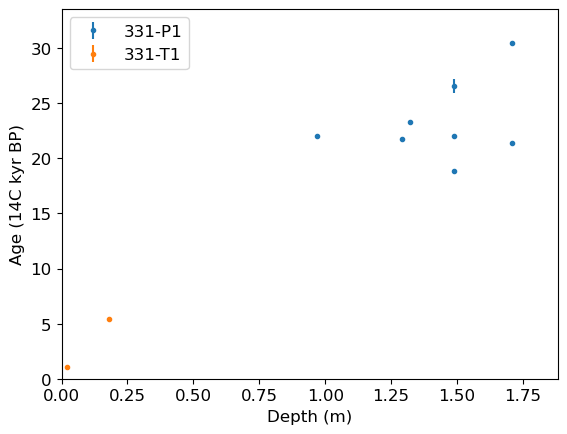

In [40]:
cores_331 = ['331-P1','331-T1']
compiplot(cores_331, [],dfall)

There are many age reversals in the data for core 331-P1. The data should be treated with caution. With caution in mind, the two options here seem to be 1) ignoring all data from 331-P1, or 2) retaining only the shallowest age, as it looks to continue linearly from the data of 331-T1. It doesn't actually matter for calculating the apparent surface age following our methodology however.

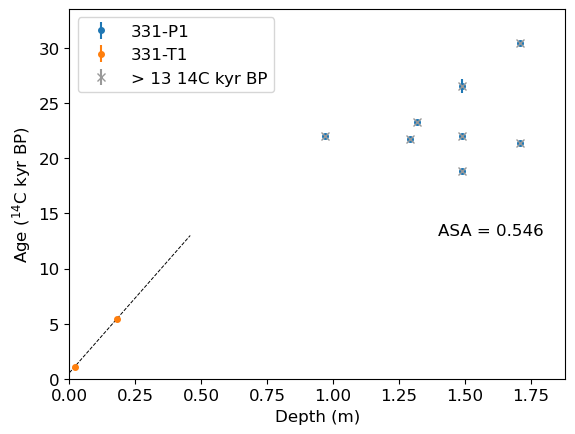

In [41]:
asa331 = ASA13_grey(cores_331, [],dfall)

#### Site VER98st5

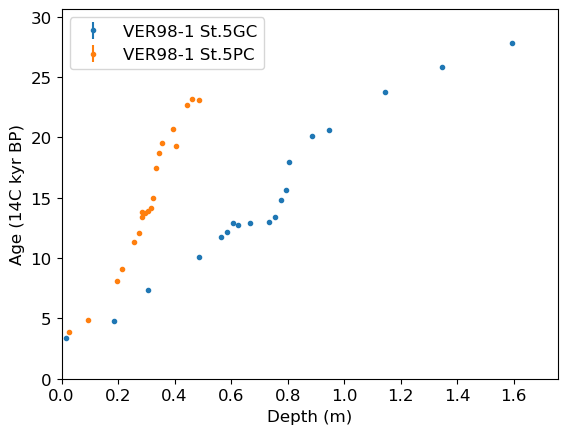

In [42]:
cores_VER98st5 = ['VER98-1 St.5GC','VER98-1 St.5PC']
compiplot(cores_VER98st5, [],dfall)

The two cores at this site show extremely different sedimentation rates, the reason for which is not clear. They do, however, both show a generally similar overall pattern, specifically in the centre of the cores, in which around 13-15 14C kyr BP there seems to have been a markedly greater sedimentation rate. Watanabe et al. (2009) have interpreted this to be a result of the atmospheric 14C fluctuation that happened at the time of the Younger Dryas. They note an approximate similarity with the other core they investigate, VER98-1 St.6GC.

Watanabe et al. (2009) suggest that VER98-1 St.5PC suffered from compression.

Because of their different sedimentation rates, we will have to perform their linear regressions separately.

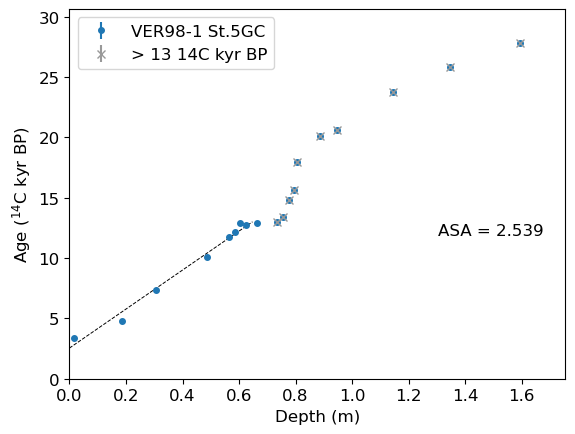

In [43]:
asaVER98st5GC = ASA13_grey(['VER98-1 St.5GC'], [],dfall)

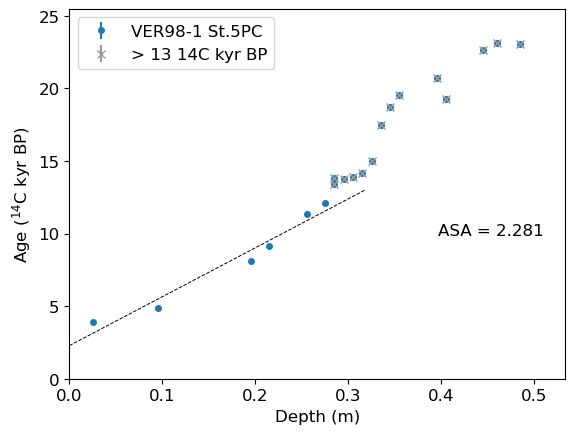

In [44]:
asaVER98st5PC = ASA13_grey(['VER98-1 St.5PC'], [],dfall)

#### Site VER98st6

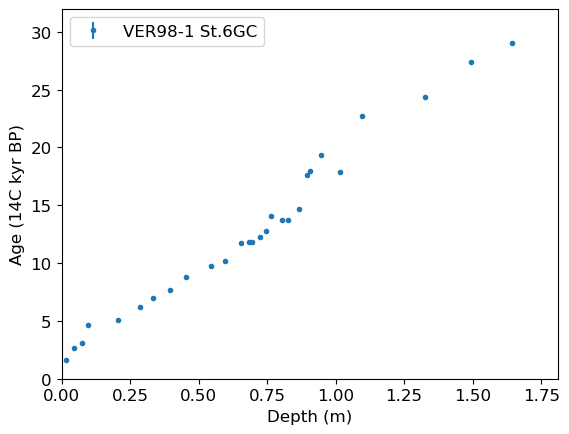

In [45]:
cores_VER98st6 = ['VER98-1 St.6GC']
compiplot(cores_VER98st6,[],dfall)

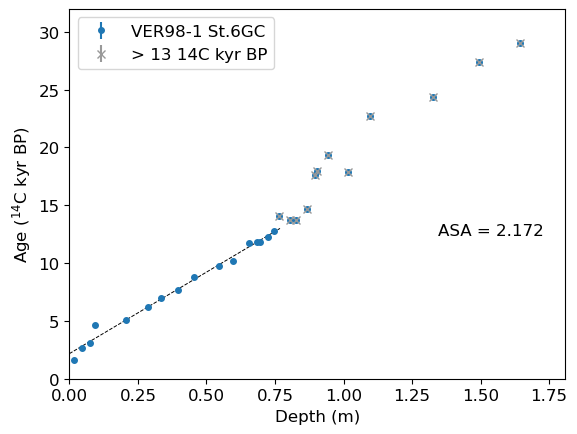

In [46]:
asaVER98st6 = ASA13_grey(cores_VER98st6, [],dfall)

#### Site VER93-2 st.4-PC

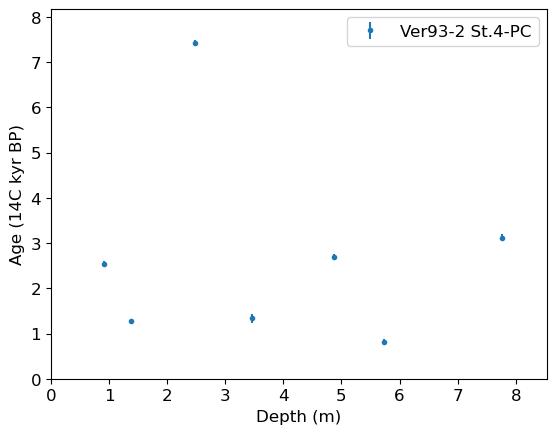

In [47]:
cores_VER93st4 = ['Ver93-2 St.4-PC']
compiplot(cores_VER93st4,[],dfall)

There is clearly no linear trend that might be fashioned by removing a few anomalies for core Ver93-2 st.4-PC, hence we suggest that linear regression on this core would be unwise.

#### Site VER94st16

Site VER94 St16 is a somewhat complicated situation. Horiuchi et al. (2001) reports a core, VER94/st.16. which is  actually a composite record of the following cores:
* Ver94-5 St.16-Pilot;
* A surface sample by a Smith-Mcintyre sediment sampler (Lab Code = NUTA-4152);

but, it does not include data from neighbouring core Ver94-5 St.16-PC, which is reported by Nakamura et al. (2003). The addition of a date from a surface sampler, in the context of this paper, is inconsistent with the fact that all other dates have come from sediment cores, not surface samplers. Hence, we do not incorporate the date from the surface sampler and we will not continue to use the core name VER94 st.16, but instead refer to the two cores Ver94-5 St.16-Pilot and Ver94-5 St.16-PC which are at the site VER94st16.

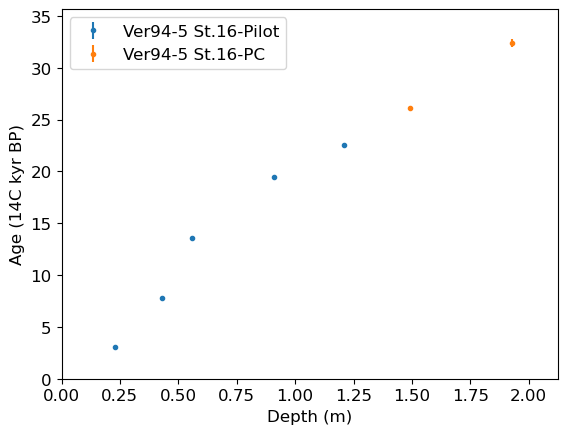

In [48]:
cores_VER94st16 = ['Ver94-5 St.16-Pilot','Ver94-5 St.16-PC']
compiplot(cores_VER94st16, [],dfall)

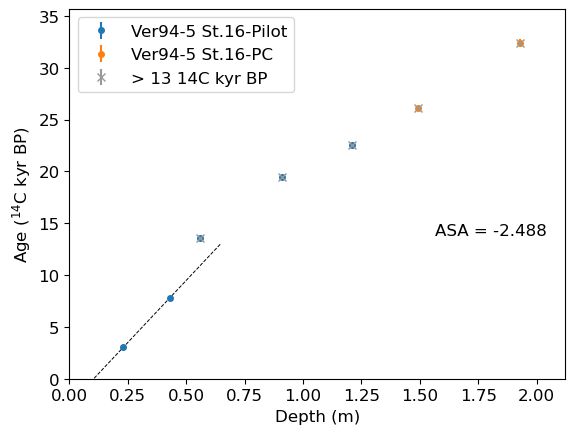

In [49]:
asaVER94st16 = ASA13_grey(cores_VER94st16,[],dfall)

We report this negative ASA in the paper (Table 2) but consider it an anomaly so do not use it when calculating the mean or standard deviation of the Academician Ridge age offset

#### Site VER94-5 St.19

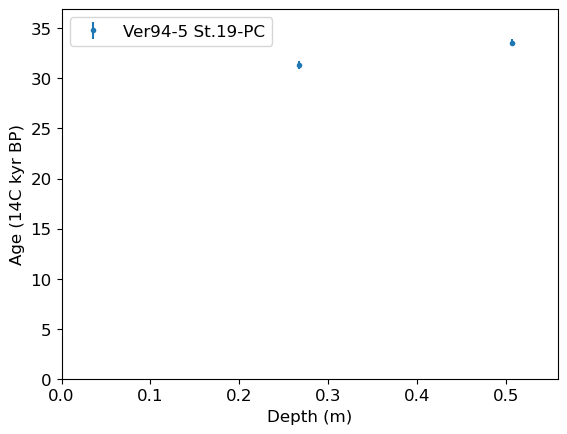

In [50]:
cores_Ver94st19 = ['Ver94-5 St.19-PC']
compiplot(cores_Ver94st19,[],dfall)

There are no ages younger than 13 14C kyr BP, hence we cannot perform our method of linear regression here.

#### Site VER96st3

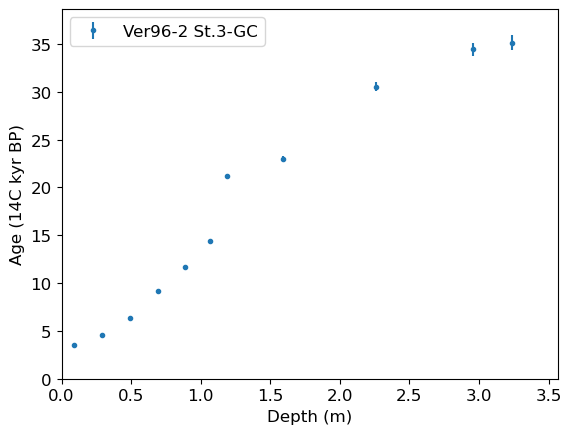

In [51]:
cores_Ver96st3 = ['Ver96-2 St.3-GC']
compiplot(cores_Ver96st3,[],dfall)

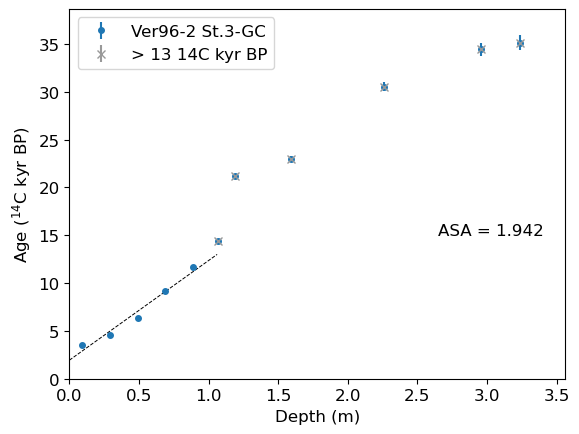

In [52]:
asaVer96st3 = ASA13_grey(cores_Ver96st3, [],dfall)

The partial non-linearity of the ages younger than 13 14C kyr BP suggests our method may be underestimating the true surface age here.

#### Site VER96st7

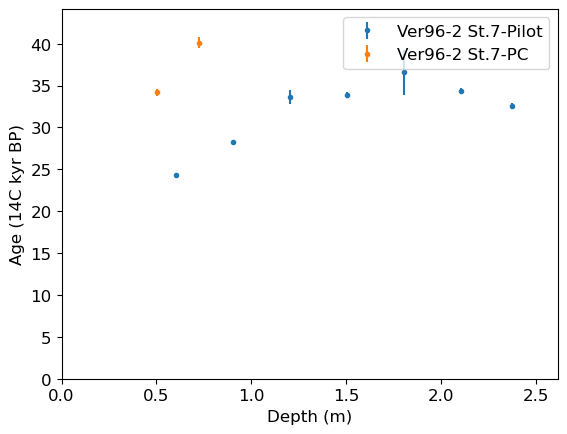

In [53]:
cores_Ver96st7 = ['Ver96-2 St.7-Pilot','Ver96-2 St.7-PC']
compiplot(cores_Ver96st7, [],dfall)

In [54]:
ASA13_grey(cores_Ver96st7, [],dfall)

'Not enough data younger than 13 14C kyr BP to perform linear regression'

#### Site Ver97st6

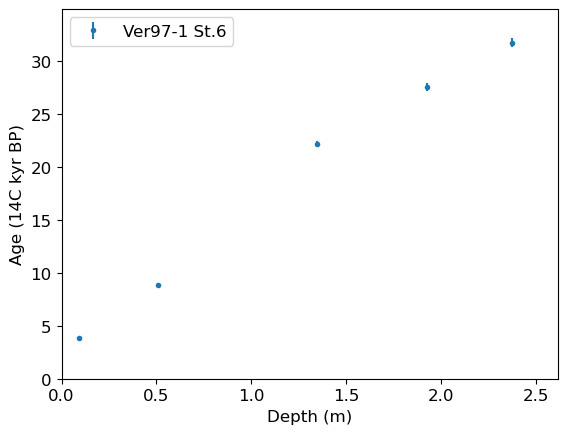

In [55]:
compiplot(['Ver97-1 St.6'], [],dfall)

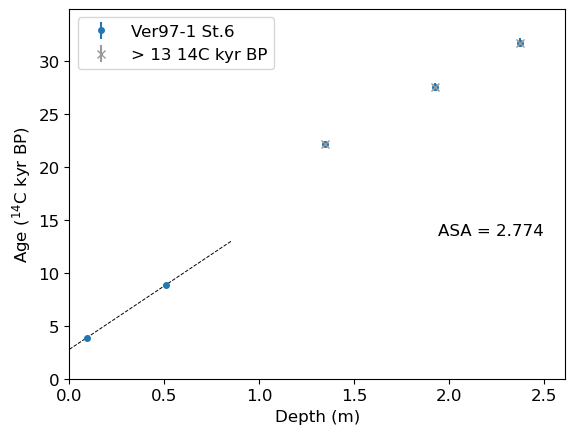

In [56]:
asaVer97st6 = ASA13_grey(['Ver97-1 St.6'], [],dfall)

#### BDP98

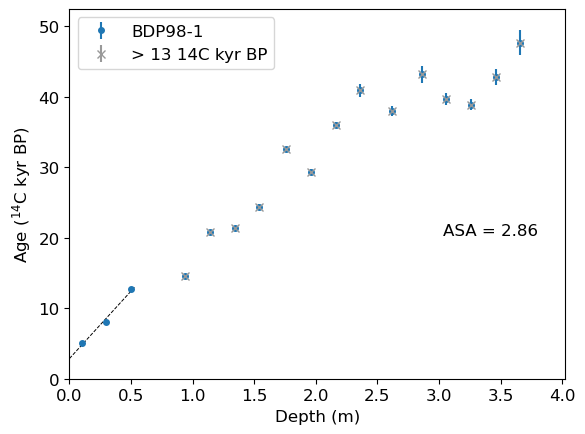

In [57]:
asaBDP98 = ASA13_grey(['BDP98-1'], [],dfall)

#### Academician Ridge Overview

We've looked at all the sites within Academician Ridge now and found

* Site 18 yields no reasonable linear pattern
* Site 333 with 4 ages <13 14C kyr BP, yields an ASA of 0.08 14C kyr BP.
* Site 340 with 5 ages <13 14C kyr BP, yields an ASA of 1.28 14C kyr BP.
* Site 307 has only 1 age <13 14C kyr BP so we cannot apply the method.
* Site 331 with 2 ages <13 14C kyr BP, yields an ASA of 0.55 14C kyr BP.
* Core Ver98-1 St.5GC with 9 ages <13 14C kyr BP yields an ASA of 2.54 14C kyr BP
* Core Ver98-1 St.5PC with 6 ages <13 14C kyr BP yields an ASA of 2.28 14C kyr BP
* Core VER98-1 St.6GC with 16 ages <13 14C kyr BP yields an ASA of 2.17 14C kyr BP
* Core VER93-2 St.4-PC yields no reasonable linear pattern
* Site Ver94st16 with 2 ages <13 14C kyr BP, yields an ASA of -2.49 14C kyr BP
* Core Ver94-5 st.19-PC does not have any ages <13 14C kyr BP upon which to apply the method
* Core Ver96-2 St.3-GC with 5 ages <13 14C kyr BP yields an ASA of 1.94 14C kyr BP
* Site Ver96st7 does not have any any ages <13 14C kyr BP upon which to apply the method
* Core Ver97-1 St.6 with 2 ages <13 14C kyr BP yields an ASA of 2.77 14C kyr BP
* Core BDP98 with 3 ages <13 14C kyr BP yields an ASA of 2.86 14C kyr BP

Therefore, the only reasonable sites whose answers to look at are:

* Site 333              (ASA = 0.08 14C kyr BP)
* Site 340              (ASA = 1.28 14C kyr BP)
* Core Ver98-1 St.5GC   (ASA = 2.54 14C kyr BP)
* Core Ver98-1 St.5PC   (ASA = 2.28 14C kyr BP)
* Core Ver98-1 St.6GC   (ASA = 2.17 14C kyr BP)
* Core Ver96-2 St.3-GC  (ASA = 1.94 14C kyr BP)
* Core Ver97-1 St.6     (ASA = 2.77 14C kyr BP)
* Core BDP9             (ASA = 2.86 14C kyr BP)

Comment : One might decide to treat site 333 as an outlier, with such a low ASA but we will continue without doing so.

In [58]:
AR_asas = [asaVER98st6, asaVER98st5GC, asa331, asa340, asa333, asaVer96st3, asaVer97st6, asaBDP98]
AR_asamean = sum(AR_asas)/len(AR_asas)
AR_asarange = max(AR_asas) - min(AR_asas)
AR_asavariance = sum((AR_asas - AR_asamean)**2 / len(AR_asas))
AR_asastd = math.sqrt(AR_asavariance)
print('The apparent surface age at Academician Ridge is '+ str(round(AR_asamean, 3))+' ± ' +str(round(AR_asastd, 3))+' 14C kyr BP, as calculated from ' + str(len(AR_asas))+ ' cores.')

print('The min and max apparent surface ages of the cores considered are '+ str(round(min(AR_asas),3))+' and '+ str(round(max(AR_asas),3))+' 14C kyr BP respectively')

The apparent surface age at Academician Ridge is 1.774 ± 0.973 14C kyr BP, as calculated from 8 cores.
The min and max apparent surface ages of the cores considered are 0.077 and 2.86 14C kyr BP respectively


### Other Locations

#### Maloe More
Maloe More has 4 cores. One at site 287 and three at site 342.

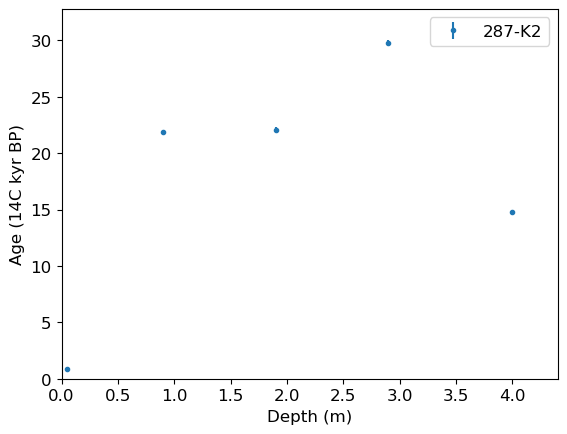

In [59]:
compiplot(['287-K2'],[],dfall)

There is not enough data to perform a linear regression for core 287-K2.

Next we look at site 342.

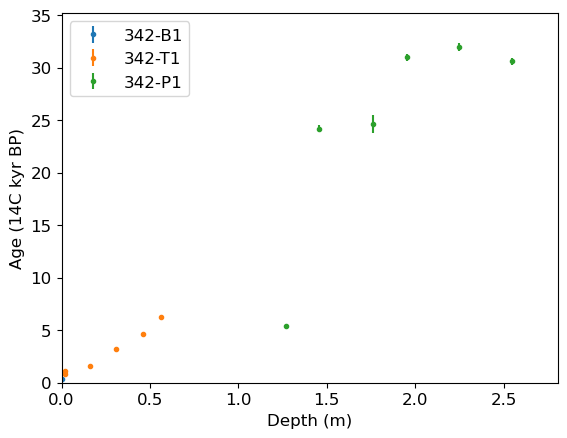

In [60]:
cores_342 = ['342-B1', '342-T1', '342-P1']
compiplot(cores_342,[],dfall)

The shallowest age from 342-P1, with Lab Code CAMS-7584, violates the law of superposition so we remove that for the linear regression.

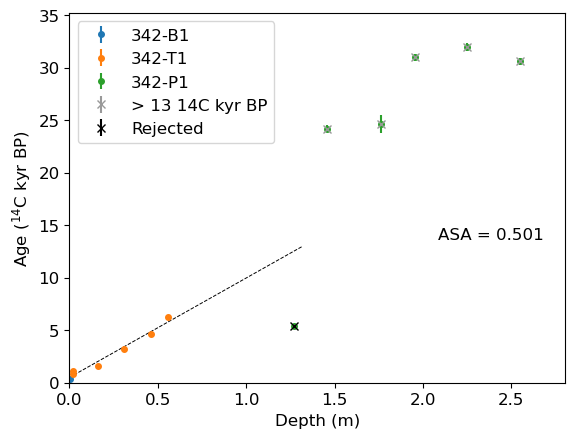

In [61]:
asa342 = ASA13_grey(cores_342,['CAMS-7584'],dfall)

#### Continent Ridge

The only core with TOC radiocarbon dates from Continent Ridges is core CON01-603-5.

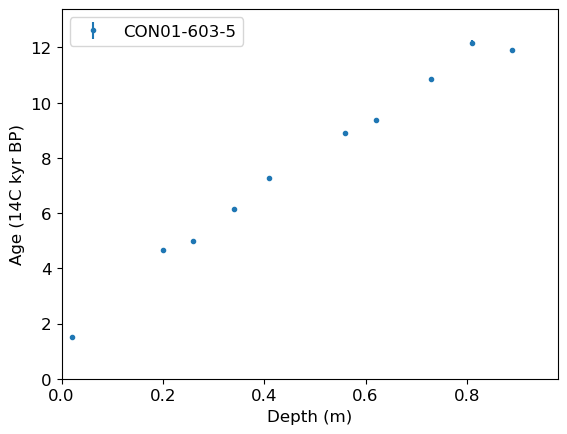

In [62]:
CR_cores = ['CON01-603-5']
compiplot(CR_cores,[],dfall)

The TOC dates from core CON01-603-5 shows a linear sedimentation profile for dates across the last 13,000 14C y BP. The only likely anomalies would be either of the oldest two dates in this portion of the core which show a reversal. Either of them could be the anomaly, however, so we could either remove one of these, or leave both. Let's look at all options.

- Option 1 - Remove no dates
- Option 2 - Remove deepest date
- Option 3 - Remove 2nd deepest date

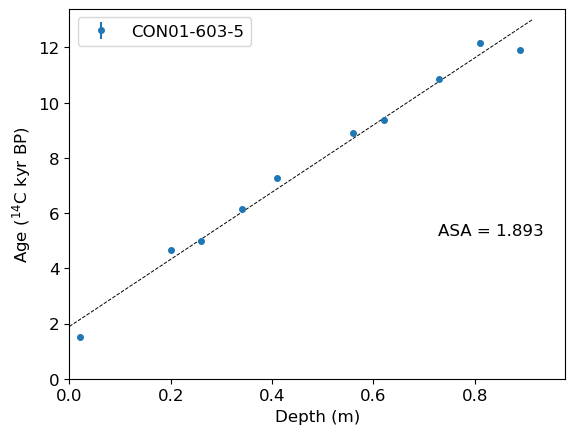

In [63]:
#Removing neither
asaCRtoc_opt1 = ASA13_grey(CR_cores, [],dfall)

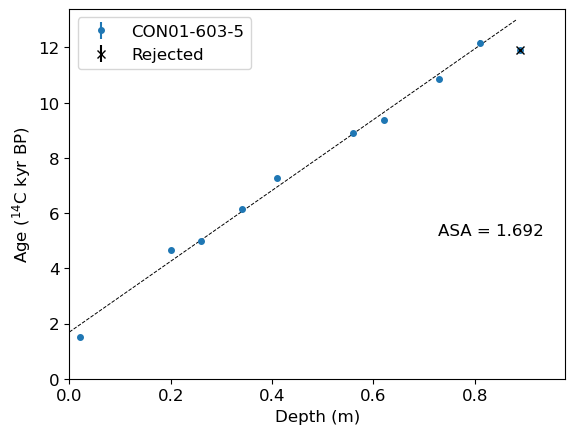

In [64]:
#Removing GdA-1379
asaCRtoc_opt2 = ASA13_grey(CR_cores, ['GdA-1379'],dfall)

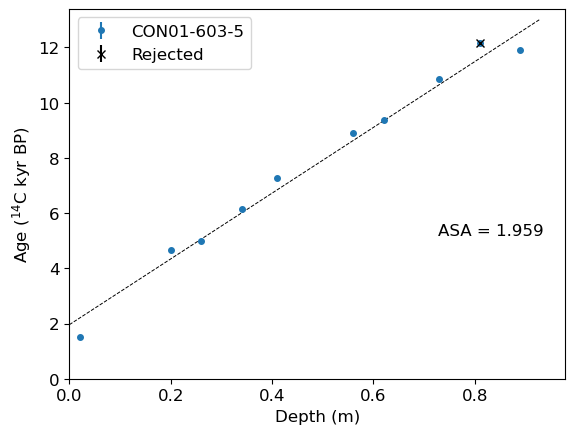

In [65]:
#Removing GdA-1378
asaCRtoc_opt3 = ASA13_grey(CR_cores, ['GdA-1378'],dfall)

There is a range of ASAs resulting from these different options, from 1692 to 1893 to 1959 14C y BP. This highlights that this method of calculating the apparent surface age is not objective and that any resulting ASA should be taken with some uncertainty when being used as an age offset.

We will use Option 1 (where we removed neither date) as our ASA estimate for this location.

#### Posolskoe Bank

Posolskoe Bank is an isolated bathymetric high south-west of Buguldeika Saddle. The two cores from this area are Ver.99 G-6 and CON01-606-3. Only core Ver.99 G-6 has TOC dates.

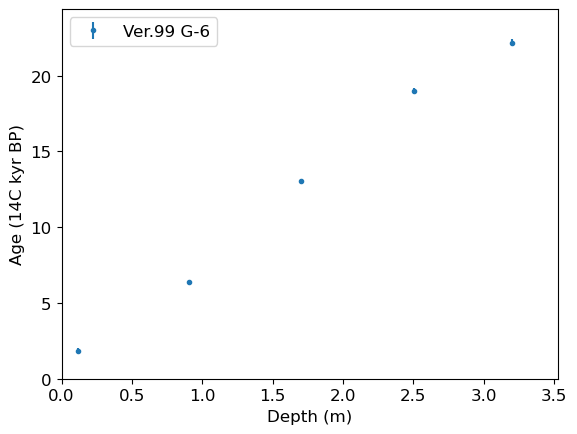

In [66]:
compiplot(['Ver.99 G-6'],[],dfall)

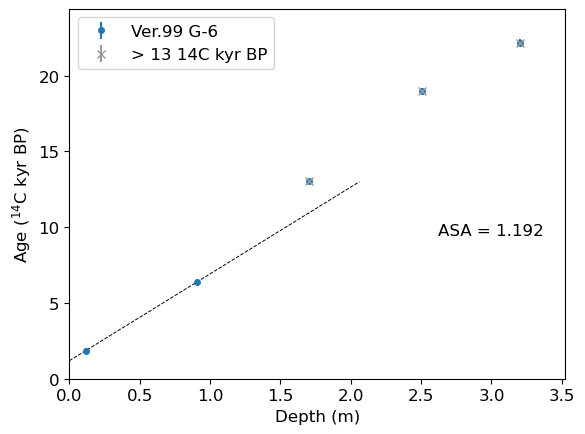

In [67]:
asaPBtoc = ASA13_grey(['Ver.99 G-6'],[],dfall)

#### Vydrino Shoulder

Vydrino Shoulder is another isolated bathymetric high in the southern region of the South Basin, with two cores, CON01-605-3 and CON01-605-5, which are from the same site so are considered together.

In [68]:
VS_cores = ['CON01-605-3','CON01-605-5']
#checkmat(VS_cores)

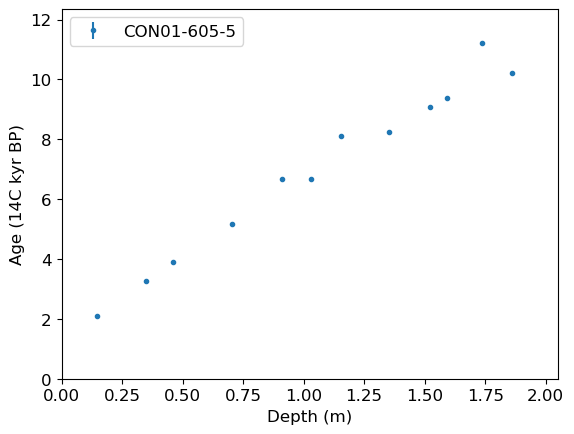

In [69]:
compiplot(['CON01-605-5'],[],dfall)

Only CON01-605-5 has TOC data (so is plotted above). Looking at the TOC data from Vydrino Shoulder, the two deepest-most ages from core CON01-605-5 show a reversal, but it's not clear which of them might be anomalous. This core also has a possible small reversal seen in the two ages in between the depths of 75 and 100cm (with Lab IDs GdA-714 and GdA-715 respectively). Their respective ages are 6680 ± 40 14C y BP and 6660 ± 40 14C y BP however, so the reversal is only very small and we will leave both dates in.

Dealing with the reversal of the bottom-most two dates, there are 3 options:
- Option 1: Leave both ages in
- Option 2: Take out the shallower age of the two
- Option 3: Take out the deeper age of the two

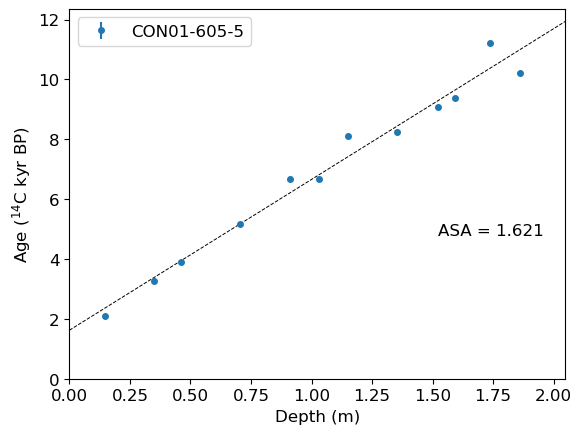

In [70]:
asaVStoc_opt1 = ASA13_grey(['CON01-605-5'],[],dfall)


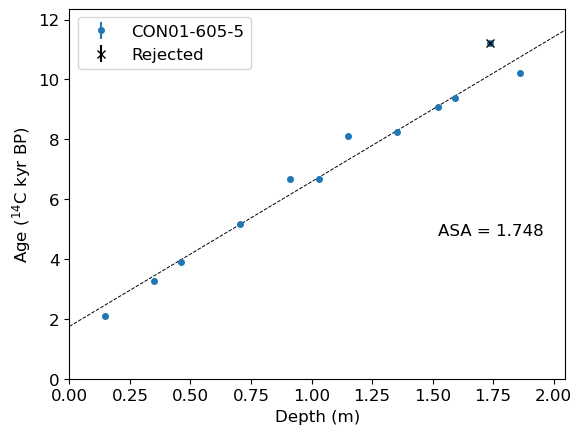

In [71]:
asaVStoc_opt2 = ASA13_grey(['CON01-605-5'],['GdA-719'],dfall)


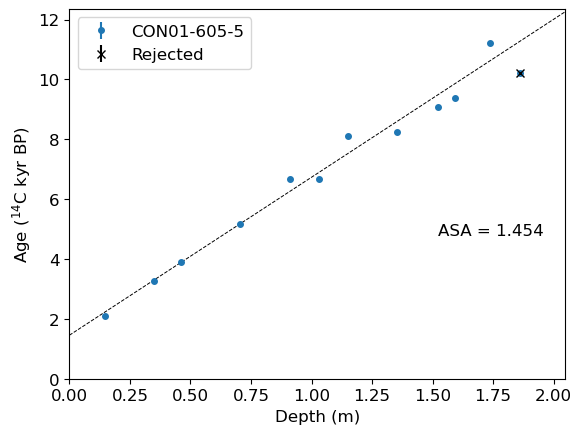

In [72]:
asaVStoc_opt3 = ASA13_grey(['CON01-605-5'],['GdA-720'],dfall)


We will use option 1 in our analysis.

#### Northern Basin

The basins typically aren't cored for paleolimnological study because they often experience large turbiditic activity which renders the sediments non-continuously deposited and therefore not ideal for such study. 

There are 2 cores from the Northern Basin: 323-PC1 and VER94-5 St.22-GC.

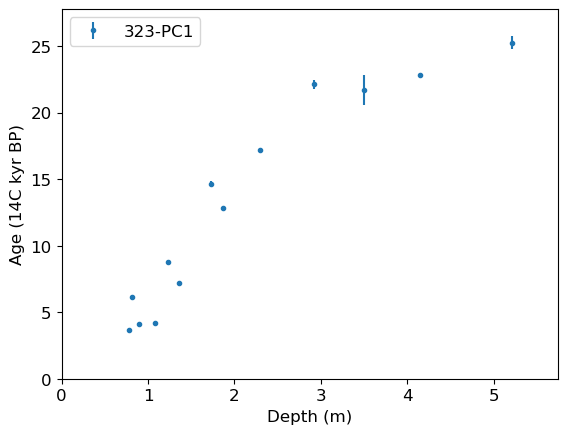

In [73]:
compiplot(['323-PC1'],[],dfall)

There is a very approximate linear pattern shown over the shallowest 300cm of the core. Looking at the data younger than 13 14C kry BP, there are many instances that violate the law of superposition and it is not clear which ages should be rejected or kept. So we run linear regression without rejecting any.

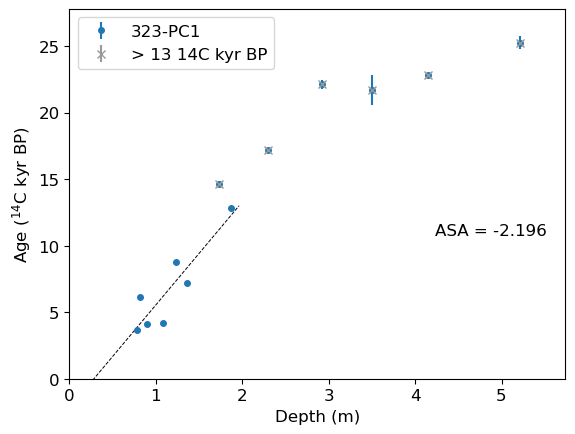

In [74]:
asa323 = ASA13_grey(['323-PC1'],[],dfall)

The non-linear set of ages younger than 13 14C kyr BP, and the large negative ASA, suggests that this is not an informative result so we will not use it.

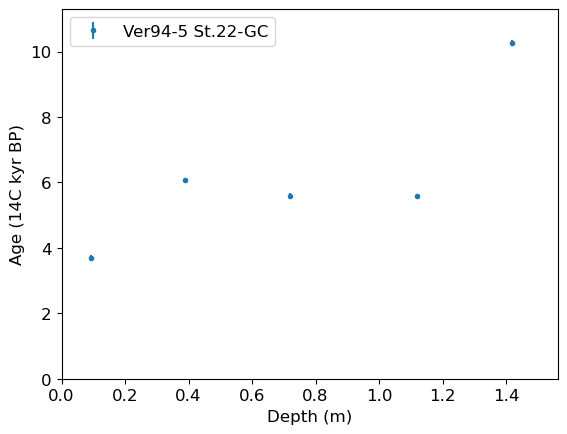

In [75]:
compiplot(['Ver94-5 St.22-GC'],[],dfall)

Core VER94-5 St.22-GC has some ages that violate the law of superposition. It is not clear that the sedimentation rate in this core was consistent over this time period. We consider the four following options:
- Option 1 - Use all ages
- Option 2,3,4 - Use 1 of the middle ages, reject the other two (3 possible permutations of this).


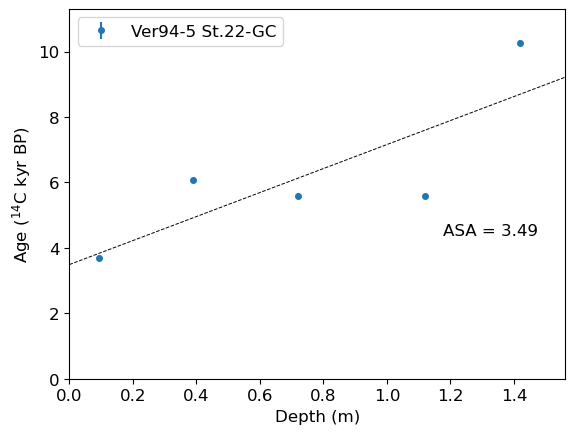

In [76]:
asaVER94st22_opt1 = ASA13_grey(['Ver94-5 St.22-GC'], [],dfall)

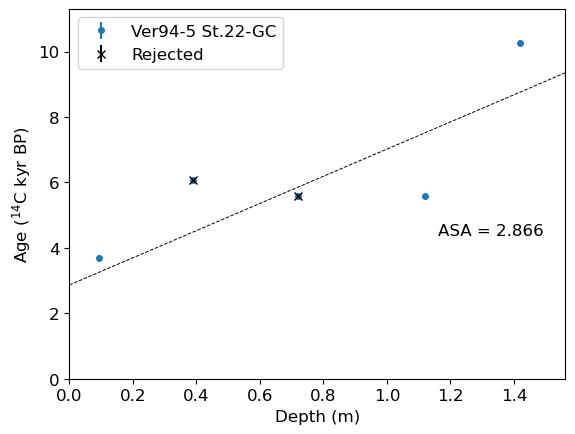

In [77]:
asaVER94st22_opt2 = ASA13_grey(['Ver94-5 St.22-GC'], ['NUTA-4106', 'NUTA-5540'],dfall)

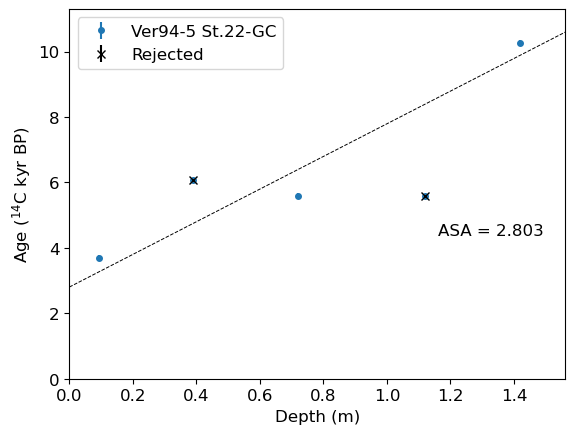

In [78]:
asaVER94st22_opt3 = ASA13_grey(['Ver94-5 St.22-GC'], ['NUTA-4106', 'NUTA-5498'],dfall)

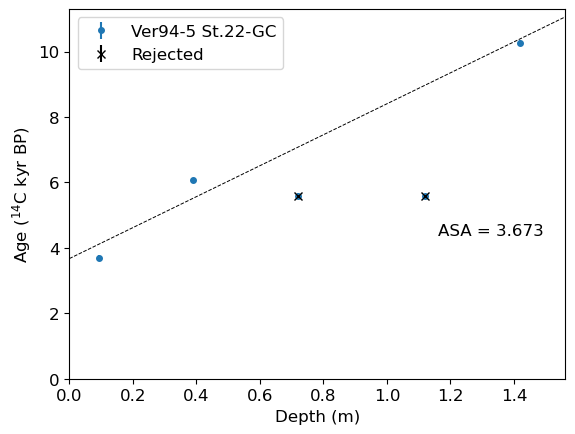

In [79]:
asaVER94st22_opt4 = ASA13_grey(['Ver94-5 St.22-GC'], ['NUTA-5540', 'NUTA-5498'],dfall)

#### Core 308-A3

Core 308-A3 is from the central basin at a depth of 1700m and has dates from TOC, POM and FOM. Colman et al. (1996) suggested that POM and FOM do not show any significant difference to each other, so it may be reasonable to treat them all as TOC ages.

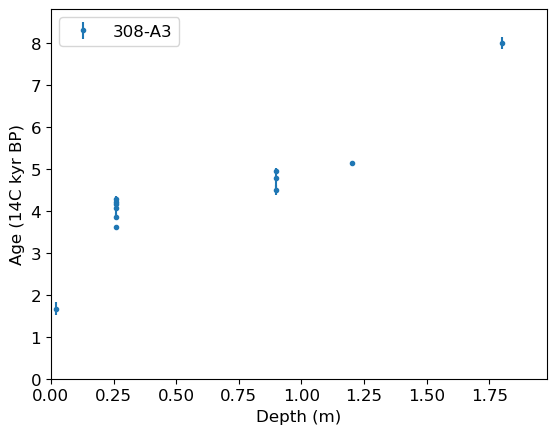

In [80]:
compiplot(['308-A3'],[],dfall)


Some depths have multiple ages, such as the 5 ages at ~25cm, which will overly impact the result. We consider four options:
- Option 1 - Use all dates
- Option 2 - Choose 1 date from each depth such that it minimizes the intercept
- Option 3 - Choose 1 date from each depth such that it maximizes the intercept
- Option 4 - Only use the TOC dates, not the FOM or POM dates.

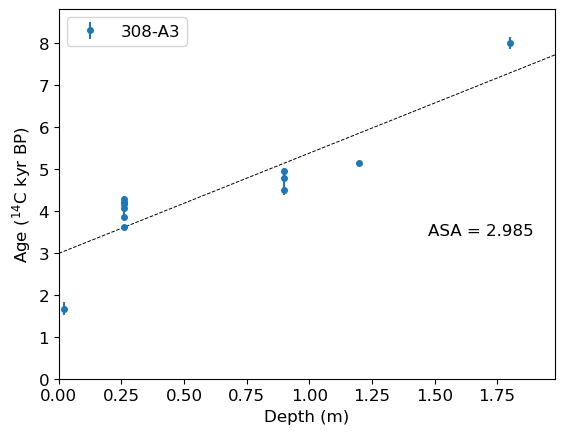

In [81]:
asa308_opt1= ASA13_grey(['308-A3'],[],dfall)


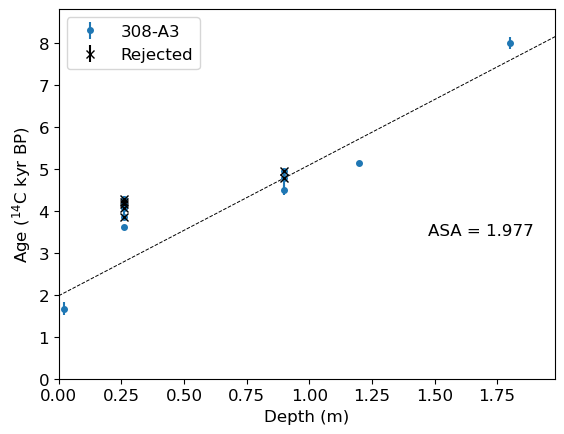

In [82]:
asa308_opt2= ASA13_grey(['308-A3'],['OS-00127', 'OS-00064', 'OS-00824', 'OS-00111', 'OS-00112', 'OS-00110', 'OS-00825'],dfall)


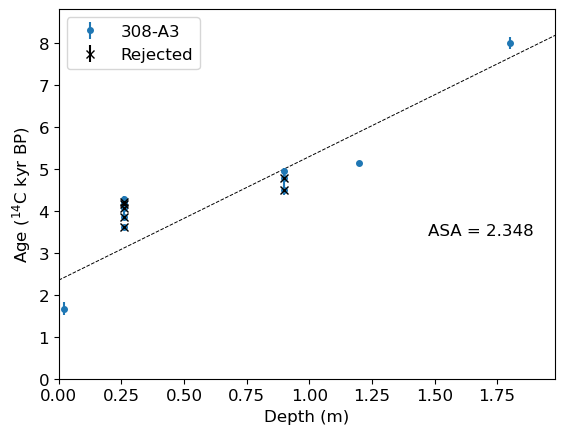

In [83]:
asa308_opt3= ASA13_grey(['308-A3'],['OS-00127', 'OS-00064', 'OS-00126', 'OS-00111', 'OS-00112', 'OS-00110', 'OS-00113'], dfall)


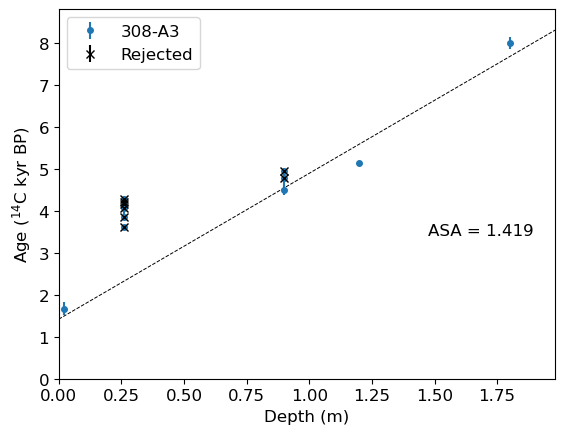

In [84]:
asa308_opt4= ASA13_grey(['308-A3'],['OS-00126','OS-00127', 'OS-00064', 'OS-00824', 'OS-00111', 'OS-00112', 'OS-00110', 'OS-00825'],dfall)


We will use Option 4, because it is most consistent with our method (using only TOC dates).

#### Southern Basin

There are three cores from the Southern Basin: BAIK13-1C, BAIK13-4F, and BDP97-1

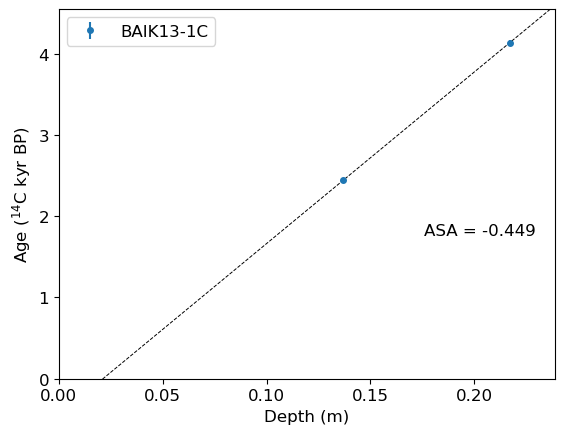

In [85]:
asaBAIK13_1C = ASA13_grey(['BAIK13-1C'],[],dfall)

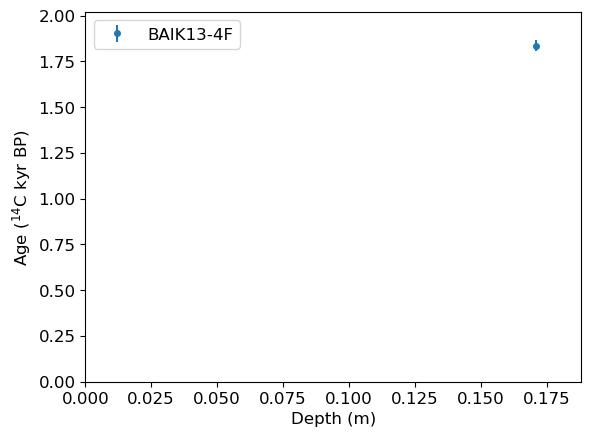

In [86]:
compiplot_grey(['BAIK13-4F'],[],dfall)

Core BAIK13-4F has only one radiocarbon age, so we cannot estimate an apparent surface age from this data.

#### BDP97

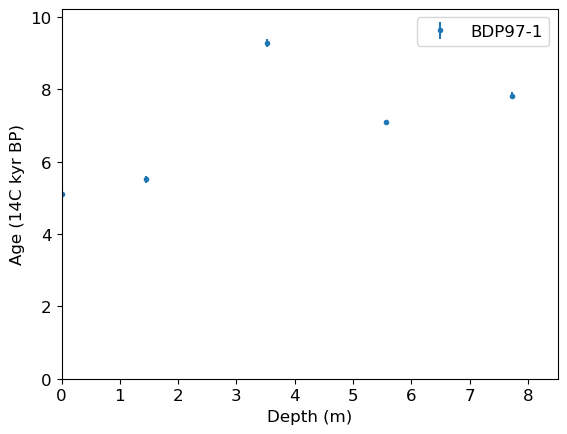

In [87]:
compiplot(['BDP97-1'],[],dfall)

Core BDP97-1 has some ages that violate the law of superposition. Based on the linear pattern suggested by the 4 younger dates, it seems like the middle date between 300 and 400 cm is not be reliable, so we remove it.

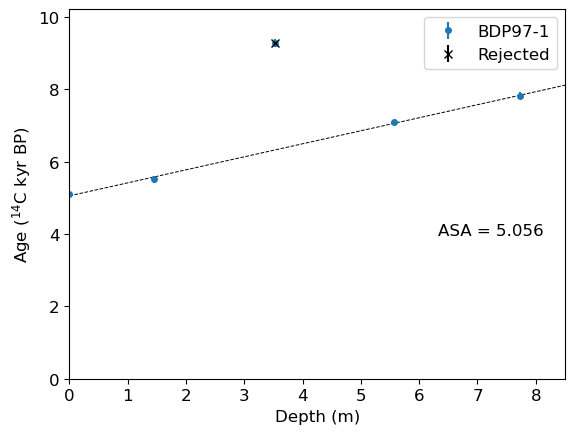

In [88]:
asaBDP97 = ASA13_grey(['BDP97-1'], ['NUTA2-0029'],dfall)


The ASA values from BDP97-1 are both much greater than most of the other values we have been finding. Two possible explanations for this are:
- The TOC in this core truly has a much greater age offset than the other cores we've looked.
- This core has a significant amount of top sediment missing, such that the top of the sediment is not truly representative of modern sediment. This sediment may be missing due to incomplete coring or because it was eroded (or never deposited) due to changes in sedimentation rates.

We believe that it is most likely that the core has significant surface sediment missing due to incomplete coring, erosion or lack of deposition.

#### Other Locations Overview

Site 342 (Maloe More) returned an ASA of 501 14C y BP.

Core CON01-603-5 (Continent Ridge) returned ASAs ranging from 1692 to 1959 14C y BP depending on what subset of ages were used. We will use the ASA that used all TOC ages, which was 1893 14C y BP.

Core Ver.99 G-6 (Posolskoe Bank) returned an ASA of 1192 14C y BP.

Site CON01-605 (Vydrino Shoulder) retunred ASAs ranging from 1454 to 1749 depending on what subset of ages were used. We will use the ASA that used all TOC ages, which was 1621 14C y BP.

Core 323-PC1 returned an ASA of -2197 14C y BP. We will reject this answer (either the dates were not good enough quality or sedimentation has not been constant throughout the last 13 14C kyr.

Core VER94-5 St.22-GC returned ASAs ranging from 2803 to 3673 14C y BP depending on what ages were rejected. We will use the ASA that used the first, third, and last TOC age, which was 2803 14C y BP.

Core 308-A3 returned ASAs ranging from 1419 to 2985 14C y BP depending on what subset of ages were used. We will use the estimate that used only the TOC estimates.

Core BAIK13-1C returned an ASA of -449.12, so we reject this answer.

Core BAIK13-4F does not have enough radiocarbon ages to return an ASA.

Core BDP97-1 returned an ASA of 5056 14C y BP. We believe this significantly larger value (than other ASAs) suggests that a large portion of the core top is missing, hence we reject this answer.



## Whole Lake

Having looked at the ASAs and estimates of age offset with a focus on sections of the lake, let us look take a whole lake view on estimating age offset. This approach is not likely to be as useful as the more partitioned approach however, as that incorporates greater information regarding the sedimentary conditions of the lake.

In [89]:
import statistics

other_asas = [asaVStoc_opt1, asaPBtoc, asaCRtoc_opt1, asa342, asa308_opt4, asaVER94st22_opt3]
AllASAs = BS_asas + AR_asas + other_asas
AllASAs_mean = statistics.mean(AllASAs)
AllASAs_std = statistics.stdev(AllASAs)
AllASAs_range = max(AllASAs)-min(AllASAs)
print('The mean apparent surface age across the whole lake is '+ str(round(AllASAs_mean,2))+' 14C kyr BP with a standard deviation of ' + str(round(AllASAs_std,2))+ ' and a range of ' +str(round(AllASAs_range, 2))+' 14C kyr BP, as calculated from ' + str(len(AllASAs))+ ' sites.')

The mean apparent surface age across the whole lake is 1.61 14C kyr BP with a standard deviation of 0.76 and a range of 2.78 14C kyr BP, as calculated from 21 sites.


In [90]:
statistics.stdev(other_asas)

0.7662442821972638

# T Test

Perform Welch's T Test to see if we can reject the null hypothesis that the age offset at Academician Ridge is different to Buguldeika Saddle.

In [91]:
import statistics
import numpy as np
import pandas as pd
import scipy
from scipy import stats

meanBS = statistics.mean(BS_asas)
meanAR = statistics.mean(AR_asas)

stdBS = statistics.stdev(BS_asas)
stdAR = statistics.stdev(AR_asas)

nBS = len(BS_asas)
nAR = len(AR_asas)

#t_test = (meanBS - meanAR)/((stdBS**2/nBS + stdAR**2/nAR)**0.5)

t, p = stats.ttest_ind(BS_asas, AR_asas, equal_var = False)

print(p)

0.4443547158600736


We cannot reject the null hypothesis, therefore there is no statistical evidence that the age offset at Academician Ridge is different to the age offset at Buguldieka Saddle.

# ASA Comparison Figure

Reviewer 1 suggested that the manuscript would benefit from a figure that communicates the results. The main results are the ASA results from each site, their average value and the uncertainty, and how they compare to each other.

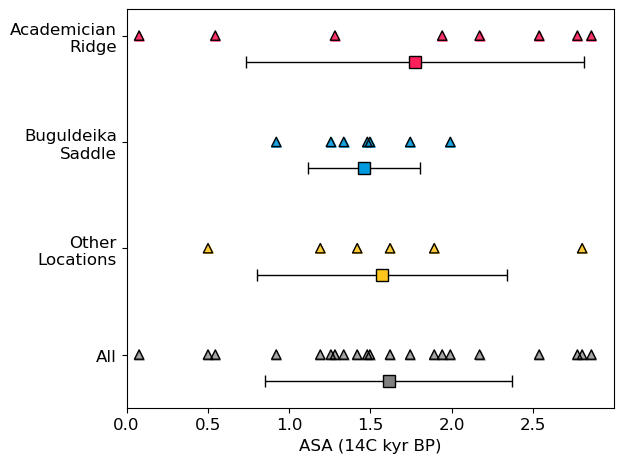

In [92]:
import statistics

#Construction of plot done with assistance from ChatGPT 5 (Thinking)

def plot_asas(AR_asas, BS_asas, other_asas,
              x_label="ASA (units)",
              title=""):
    """
    Creates a horizontal strip-plot comparing ASA values
    from three site categories (AR, BS, Other) plus all points.

    Parameters
    ----------
    AR_asas : array-like
        ASA values for Academician Ridge cores
    BS_asas : array-like
        ASA values for Buguldeika Saddle cores
    other_asas : array-like
        ASA values for other cores
    x_label : str, optional
        Label for the x-axis
    title : str, optional
        Title for the figure
    """

    # Convert to numpy arrays
    AR_asas = np.asarray(AR_asas, dtype=float)
    BS_asas = np.asarray(BS_asas, dtype=float)
    other_asas = np.asarray(other_asas, dtype=float)
    all_asas = np.concatenate([AR_asas, BS_asas, other_asas])
    
    # Calculate mean and std
    meanBS = statistics.mean(BS_asas)
    meanAR = statistics.mean(AR_asas)
    meanOther = statistics.mean(other_asas)
    meanAll = statistics.mean(all_asas)

    stdBS = statistics.stdev(BS_asas)
    stdAR = statistics.stdev(AR_asas)
    stdOther=statistics.stdev(other_asas)
    stdAll=statistics.stdev(all_asas)

    # y levels: AR=4, BS=3, Other=2, All=1
    y_ar = np.full_like(AR_asas, 4, dtype=float)
    y_bs = np.full_like(BS_asas, 3, dtype=float)
    y_other = np.full_like(other_asas, 2, dtype=float)
    y_all = np.full_like(all_asas, 1, dtype=float)


    #Plot asas (transparent faces but solid marker boundaries)
    plt.scatter(AR_asas, y_ar, s=42, marker='^',
                facecolors='#FF1F5B', edgecolors='face', alpha=0.9, label="AR")
    plt.scatter(AR_asas, y_ar, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="AR")
    
    
    plt.scatter(BS_asas, y_bs, s=45, marker='^',
                facecolors='#009ADE', edgecolors='face', alpha=0.9, label="BS")
    plt.scatter(BS_asas, y_bs, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="BS")
    
    
    plt.scatter(other_asas, y_other, s=45, marker='^',
                facecolors='#FFC61E', edgecolors='face', alpha=0.9, label="Other")
    plt.scatter(other_asas, y_other, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="Other")
    
    
    plt.scatter(all_asas, y_all , s=45, marker='^',
                facecolors='gray', edgecolors='face', alpha=0.7, label="All")
    plt.scatter(all_asas, y_all , s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="All")
    
    #Plot means and standard deviations
    plt.errorbar(meanAR, y_ar[1]-0.25, xerr=stdAR, fmt='s',
             markersize=8, markerfacecolor='#FF1F5B', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    plt.errorbar(meanBS, y_bs[1]-0.25, xerr=stdBS, fmt='s',
             markersize=8, markerfacecolor='#009ADE', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    plt.errorbar(meanOther, y_other[1]-0.25, xerr=stdOther, fmt='s',
             markersize=8, markerfacecolor='#FFC61E', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    plt.errorbar(meanAll, y_all[1]-0.25, xerr=stdAll, fmt='s',
             markersize=8, markerfacecolor='grey', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    # Axes formatting
    plt.yticks([1, 2, 3, 4], ["All", "Other\nLocations", "Buguldeika\nSaddle", "Academician\nRidge"])
    nanmin = np.nanmin(all_asas)
    nanmax = np.nanmax(all_asas)
    span = nanmax - nanmin if np.isfinite(nanmax - nanmin) else 1.0
    xmin = max(0, nanmin - 0.05 * span)
    xmax = nanmax + 0.05 * span
    plt.xlim(xmin, xmax)
    plt.ylim(0.5, 4.25)
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    
plot_asas(AR_asas, BS_asas, other_asas, x_label="ASA (14C kyr BP)", title="")
plt.savefig("../figures/ASAcomparison.png", dpi=300, bbox_inches="tight")

In plotting the confidence intervals symmetrically we are assuming that the data are symmetrically distributed around the mean. A simple such assumption is that the data are normally distributed. To ensure that this is a reasonable assumption, let us run the Shapiro-Wilks test, which tests the null hypothesis that the data are normally distributed, for each subset of data.

In [93]:
SWstatAR, SWpAR = stats.shapiro(AR_asas)
SWstatBS, SWpBS = stats.shapiro(BS_asas)
SWstatOther, SWpOther = stats.shapiro(other_asas)
SWstatAll, SWpAll = stats.shapiro(AllASAs)

print("Shapiro-Wilk statistics:\n"+ f"AR data: test: {SWstatAR:.4f}, p-value: {SWpAR:.4f}\n"
      + f"BS data: test: {SWstatBS:.4f}, p-value: {SWpBS:.4f}\n"
      + f"Other data: test: {SWstatOther:.4f}, p-value: {SWpOther:.4f}\n"
      + f"All data: test: {SWstatAll:.4f}, p-value: {SWpAll:.4f}\n")

Shapiro-Wilk statistics:
AR data: test: 0.9066, p-value: 0.3310
BS data: test: 0.9846, p-value: 0.9787
Other data: test: 0.9784, p-value: 0.9431
All data: test: 0.9679, p-value: 0.6861



At the 0.05-confidence level there is no evidence to reject the hypothesis that each dataset are normally distributed, so the use of symmetrical error bars is reasonable, and we interpret the 1-sigma interval to represent the 68% confidence intervals. 